In [1]:
import sys
!{sys.executable} -m pip install tabulate


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tabulate import tabulate

## Preliminary Analysis


In [3]:
file_path = 'Unipol_dataset_lab3.csv' 
data = pd.read_csv(file_path)
print(f"Number of records: {len(data)}")
unique_trips = data[['vehicle_id', 'trip_id']].drop_duplicates()
print(f"Number of unique trips: {len(unique_trips)}")
print(f"Number of unique vehicles: {data['vehicle_id'].nunique()}")

Number of records: 1415305
Number of unique trips: 966000
Number of unique vehicles: 1000


In [4]:
data.head()

,Unnamed: 0,vehicle_id,trip_id,start_time,stop_time,road,total_distance
0,0,1,0,2023-09-29 13:55:35,2023-09-29 14:11:42,E,14.31
1,1,1,0,2023-09-29 13:55:35,2023-09-29 14:11:42,U,1.47
2,2,1,1,2023-09-29 14:32:24,2023-09-29 14:34:31,U,0.03
3,3,1,2,2023-09-29 15:12:03,2023-09-29 15:26:55,E,2.60
4,4,1,2,2023-09-29 15:12:03,2023-09-29 15:26:55,U,2.00


In [5]:
# Example: Show how trip 0 of vehicle 1 is structured
print("Example of how data is structured - Trip 0 of Vehicle 1:")
print(data[(data['vehicle_id'] == 1) & (data['trip_id'] == 0)])

Example of how data is structured - Trip 0 of Vehicle 1:
   Unnamed: 0  vehicle_id  trip_id           start_time            stop_time  \
0           0           1        0  2023-09-29 13:55:35  2023-09-29 14:11:42   
1           1           1        0  2023-09-29 13:55:35  2023-09-29 14:11:42   

  road  total_distance  
0    E           14.31  
1    U            1.47  


In [6]:
data_cleaned = data.dropna(subset=['vehicle_id', 'trip_id', 'road', 'start_time', 'stop_time', 'total_distance'])
data_cleaned['start_time'] = pd.to_datetime(data_cleaned['start_time'])
data_cleaned['stop_time'] = pd.to_datetime(data_cleaned['stop_time'])

data_cleaned['trip_duration'] = (data_cleaned['stop_time'] - data_cleaned['start_time']).dt.total_seconds() / 60.0

data_cleaned['road'] = data_cleaned['road'].replace('_', 'unknown')

print(f"Number of records after cleaning: {len(data_cleaned)}")

Number of records after cleaning: 1415305


• What is the distribution of trip distance of different types of roads? Plot ecdf and make comments.

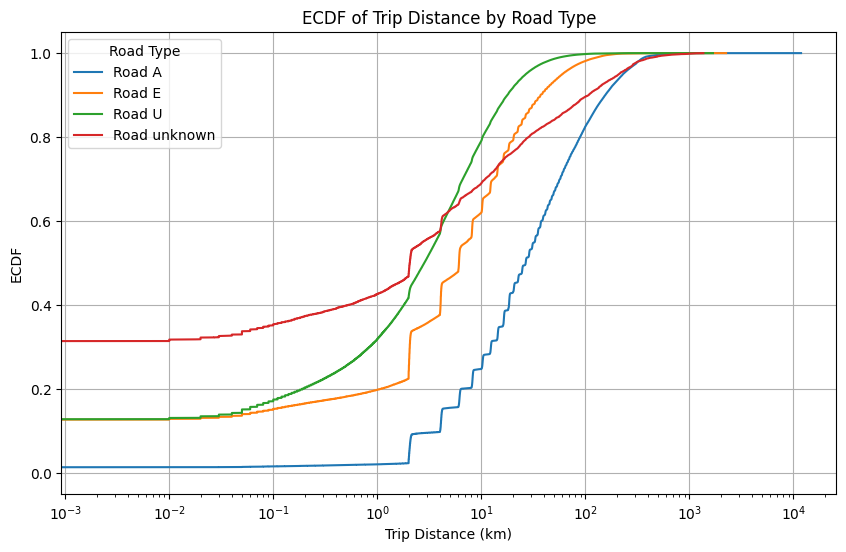

In [7]:
road_duration = data_cleaned.groupby('road')

def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

# Plot ECDF for each road type
plt.figure(figsize=(10, 6))
for road, group in road_duration:
    x, y = ecdf(group['total_distance'])
    plt.semilogx(x, y, label=f'Road {road}')

# Customize the plot
plt.title('ECDF of Trip Distance by Road Type')
plt.xlabel('Trip Distance (km)')
plt.ylabel('ECDF')
plt.legend(title='Road Type')
plt.grid(True)

• What is the distribution of trip duration? Plot ecdf and make comments.

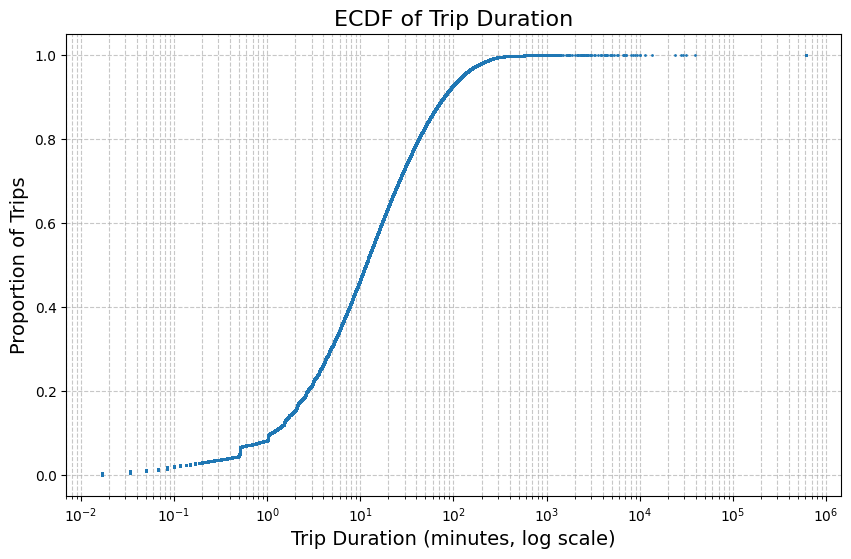

In [8]:
# Get one record per trip (duration is already calculated correctly above)
unique_trips = data_cleaned.drop_duplicates(subset=['vehicle_id', 'trip_id']).copy()

# Filter out zero/negative durations (essential for log scale)
unique_trips = unique_trips[unique_trips['trip_duration'] > 0]

def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

plt.figure(figsize=(10, 6))

x, y = ecdf(unique_trips['trip_duration'])

# Plotting
plt.plot(x, y, marker='.', linestyle='none', markersize=2) 

plt.title('ECDF of Trip Duration', fontsize=16)
plt.xlabel('Trip Duration (minutes, log scale)', fontsize=14)
plt.ylabel('Proportion of Trips', fontsize=14)
plt.grid(True, which='both', linestyle='--', alpha=0.7)

# Set Log Scale
plt.xscale('log')

plt.show()

• What is the relationship between trip duration and distance? Can you spot any difference among
trips with different road types?


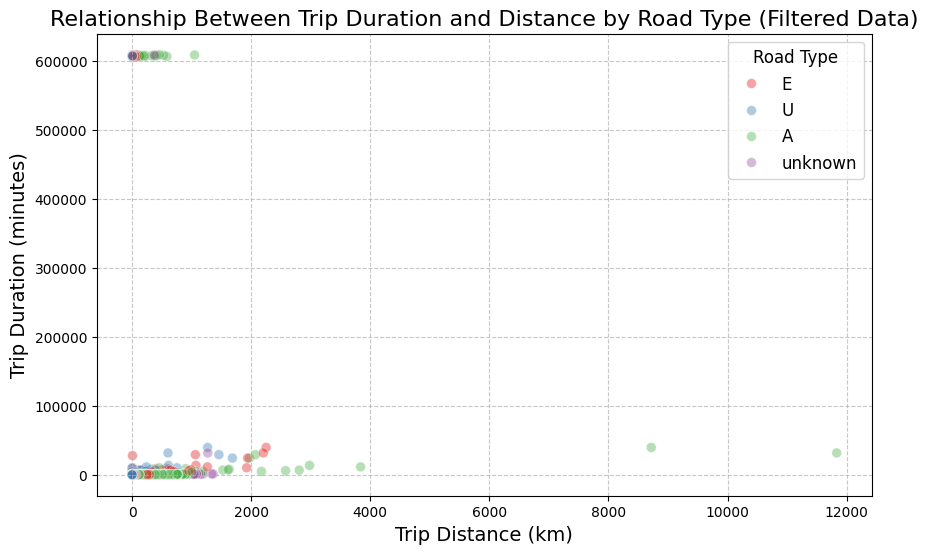

In [9]:
# Scatter plot with regression lines for each road type (filtered data)
plt.figure(figsize=(10, 6))

# Scatter points
sns.scatterplot(
    data=data_cleaned,
    x='total_distance',
    y='trip_duration',
    hue='road',
    palette='Set1',
    s=50,        # marker size
    alpha=0.4
)

# Customize the plot
plt.title('Relationship Between Trip Duration and Distance by Road Type (Filtered Data)', fontsize=16)
plt.xlabel('Trip Distance (km)', fontsize=14)
plt.ylabel('Trip Duration (minutes)', fontsize=14)
plt.legend(title='Road Type', fontsize=12, title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.show()

In [19]:
min_distance = 0.1  # km
max_distance = 1000  # km
min_duration = 2    # minutes
max_duration = 600  # minutes (10 hours)
min_speed = 1       # km/h
max_speed = 200     # km/h

print(f"Number of records before filtering: {len(data_cleaned)}")

# Filter dataset: Remove rows with zero or negative distance/duration
filtered_data = data_cleaned[
    (data_cleaned['total_distance'] > min_distance) &
    (data_cleaned['total_distance'] <= max_distance) &
    (data_cleaned['trip_duration'] > min_duration) &
    (data_cleaned['trip_duration'] <= max_duration)
].copy()

# Calculate average speed (km/h) and filter based on speed thresholds
filtered_data['average_speed'] = (
    filtered_data['total_distance'] / (filtered_data['trip_duration'] / 60)
)

filtered_data = filtered_data[
    (filtered_data['average_speed'] >= min_speed) &
    (filtered_data['average_speed'] <= max_speed)
]

# Count the number of valid trips
valid_trip_count = len(filtered_data)

# Display the filtering criteria and valid trip count
print("Filtering Criteria:")
print(f"1. Total distance > {min_distance} km and ≤ {max_distance} km")
print(f"2. Trip duration > {min_duration} minutes and ≤ {max_duration} minutes")
print(f"3. Average speed between {min_speed} km/h and {max_speed} km/h")
print(f"Number of valid trips: {valid_trip_count}")

Number of records before filtering: 1415305
Filtering Criteria:
1. Total distance > 0.1 km and ≤ 1000 km
2. Trip duration > 2 minutes and ≤ 600 minutes
3. Average speed between 1 km/h and 200 km/h
Number of valid trips: 1149664


In [20]:
# count the number of trips using just one road type
single_road_trips = filtered_data.groupby(['vehicle_id', 'trip_id']).filter(
    lambda x: x['road'].nunique() == 1
)
num_single_road_trips = len(single_road_trips)
total_trips = len(unique_trips)
percentage_single_road_trips = (num_single_road_trips / total_trips) * 100

print(f"Number of trips using just one road type: {num_single_road_trips}")
print(f"Total number of trips: {total_trips}")
print(f"Percentage of trips using just one road type: {percentage_single_road_trips:.2f}%")

Number of trips using just one road type: 439659
Total number of trips: 962259
Percentage of trips using just one road type: 45.69%


In [21]:
filtered_data.head()

,Unnamed: 0,vehicle_id,trip_id,start_time,stop_time,road,total_distance,trip_duration,average_speed
0,0,1,0,2023-09-29 13:55:35,2023-09-29 14:11:42,E,14.31,16.116667,53.274043
1,1,1,0,2023-09-29 13:55:35,2023-09-29 14:11:42,U,1.47,16.116667,5.472596
3,3,1,2,2023-09-29 15:12:03,2023-09-29 15:26:55,E,2.60,14.866667,10.493274
4,4,1,2,2023-09-29 15:12:03,2023-09-29 15:26:55,U,2.00,14.866667,8.071749
5,5,1,3,2023-09-29 15:37:38,2023-09-29 15:57:26,E,2.24,19.800000,6.787879


/home/cavallinux/Backup/Magistrale/ICT4SmartMobility/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


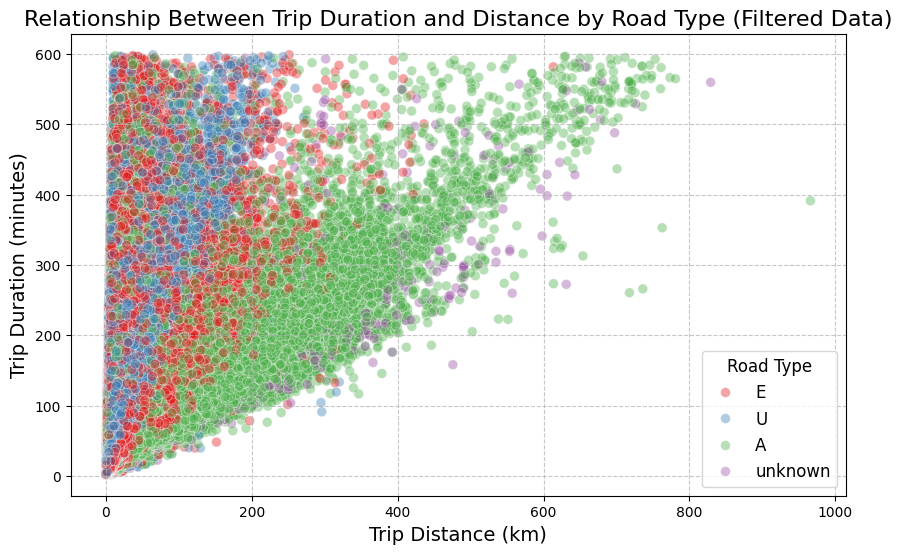

In [22]:
# Scatter plot with regression lines for each road type (filtered data)
plt.figure(figsize=(10, 6))

# Scatter points
sns.scatterplot(
    data=filtered_data,
    x='total_distance',
    y='trip_duration',
    hue='road',
    palette='Set1',
    s=50,        # marker size
    alpha=0.4
)

# Customize the plot
plt.title('Relationship Between Trip Duration and Distance by Road Type (Filtered Data)', fontsize=16)
plt.xlabel('Trip Distance (km)', fontsize=14)
plt.ylabel('Trip Duration (minutes)', fontsize=14)
plt.legend(title='Road Type', fontsize=12, title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.show()

• Filter the dataset, remove outliers (e.g. distance 0, impossible distance wrt duration) and report your
filter criteria. How many valid trips are recorded in the dataset?

In [23]:
print(f"Number of records before filtering: {len(data_cleaned)}")

# Aggregate at trip level first since each row is a road segment
# Sum up the distances from all road segments to get total trip distance
trips_aggregated = data_cleaned.groupby(['vehicle_id', 'trip_id']).agg({
    'start_time': 'first',         # Same for all segments in a trip
    'stop_time': 'first',           # Same for all segments in a trip
    'total_distance': 'sum',        # Sum distances across all road segments
    'trip_duration': 'first'        # Same for all segments in a trip (already calculated)
}).reset_index()

# Filter dataset based on TRIP-level metrics
filtered_trips = trips_aggregated[
    (trips_aggregated['total_distance'] > min_distance) &
    (trips_aggregated['total_distance'] <= max_distance) &
    (trips_aggregated['trip_duration'] > min_duration) &
    (trips_aggregated['trip_duration'] <= max_duration)
].copy()

# Calculate average speed using TOTAL trip distance and TOTAL trip duration
filtered_trips['average_speed'] = (
    filtered_trips['total_distance'] / (filtered_trips['trip_duration'] / 60)
)

# Filter based on speed
filtered_trips = filtered_trips[
    (filtered_trips['average_speed'] >= min_speed) &
    (filtered_trips['average_speed'] <= max_speed)
]

# Count valid trips
valid_trip_count = len(filtered_trips)

print("Filtering Criteria:")
print(f"1. Total trip distance > {min_distance} km and <= {max_distance} km")
print(f"2. Trip duration > {min_duration} minutes and <= {max_duration} minutes")
print(f"3. Average speed between {min_speed} km/h and {max_speed} km/h")
print(f"Number of valid trips: {valid_trip_count}")

Number of records before filtering: 1415305
Filtering Criteria:
1. Total trip distance > 0.1 km and <= 1000 km
2. Trip duration > 2 minutes and <= 600 minutes
3. Average speed between 1 km/h and 200 km/h
Number of valid trips: 739862


In [24]:
filtered_trips['date'] = filtered_trips['start_time'].dt.date
filtered_trips['day_type'] = filtered_trips['start_time'].dt.weekday.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

In [25]:
filtered_trips

,vehicle_id,trip_id,start_time,stop_time,total_distance,trip_duration,average_speed,date,day_type
0,1,0,2023-09-29 13:55:35,2023-09-29 14:11:42,15.78,16.116667,58.746639,2023-09-29,Weekday
2,1,2,2023-09-29 15:12:03,2023-09-29 15:26:55,4.60,14.866667,18.565022,2023-09-29,Weekday
3,1,3,2023-09-29 15:37:38,2023-09-29 15:57:26,4.25,19.800000,12.878788,2023-09-29,Weekday
6,1,6,2023-09-30 05:05:39,2023-09-30 05:28:37,1.21,22.966667,3.161103,2023-09-30,Weekend
8,1,8,2023-09-30 06:07:07,2023-09-30 06:33:53,5.08,26.766667,11.387298,2023-09-30,Weekend
...,...,...,...,...,...,...,...,...,...
965991,1000,470,2023-11-26 16:27:39,2023-11-27 00:13:05,31.58,465.433333,4.071045,2023-11-26,Weekend
965992,1000,471,2023-11-27 11:40:36,2023-11-27 14:10:15,20.72,149.650000,8.307384,2023-11-27,Weekday
965993,1000,472,2023-11-27 17:14:33,2023-11-28 00:07:48,18.70,413.250000,2.715064,2023-11-27,Weekday
965994,1000,473,2023-11-28 09:17:51,2023-11-28 13:06:43,84.30,228.866667,22.100204,2023-11-28,Weekday


In [26]:
# aggregate data on daily basis for each vehicle and road type
daily_aggregation = filtered_trips.groupby(['vehicle_id', 'date', 'day_type']).agg(
    total_distance=('total_distance', 'sum'),   # compute total distance by summing up distances
    total_trip_duration=('trip_duration', 'sum'),   # compute total trip duration by summing up durations
    num_trips=('trip_id', 'nunique')    # count unique trips id
).reset_index()

# evaluate daily utilization of each vehicle
daily_aggregation['daily_utilization'] = daily_aggregation.groupby(['vehicle_id', 'date'])['total_trip_duration'].transform('sum') / (24 * 60)  # 24 hours

In [27]:
daily_aggregation

,vehicle_id,date,day_type,total_distance,total_trip_duration,num_trips,daily_utilization
0,1,2023-09-29,Weekday,24.630,50.783333,3,0.035266
1,1,2023-09-30,Weekend,11.030,67.333333,5,0.046759
2,1,2023-10-01,Weekend,361.539,268.983333,1,0.186794
3,1,2023-10-02,Weekday,725.195,562.733333,7,0.390787
4,1,2023-10-03,Weekday,519.450,477.033333,7,0.331273
...,...,...,...,...,...,...,...
55263,1000,2023-11-20,Weekday,12.860,252.316667,1,0.175220
55264,1000,2023-11-24,Weekday,11.000,155.566667,1,0.108032
55265,1000,2023-11-26,Weekend,31.580,465.433333,1,0.323218
55266,1000,2023-11-27,Weekday,39.420,562.900000,2,0.390903


**1.a.** Compute the statistics and distribution of the values on workdays and weekends/holidays.
Can you find any difference? Can you find some vehicles behave consistently?

In [28]:
# extract the amount of total trips during weekdays and weekends
fraction_data = daily_aggregation.groupby(['vehicle_id', 'day_type'], as_index=False).agg(
    num_trips=('num_trips', 'sum'),
    average_trip_duration=('total_trip_duration', 'mean'),
)

# Calculate fraction per vehicle and day type (normalize within each day_type group)
fraction_data['fraction'] = fraction_data.groupby('day_type')['num_trips'].transform(lambda x: x / x.sum())

In [29]:
fraction_data

,vehicle_id,day_type,num_trips,average_trip_duration,fraction
0,1,Weekday,357,504.097037,0.000622
1,1,Weekend,49,243.045833,0.000295
2,2,Weekday,221,659.347348,0.000385
3,2,Weekend,18,416.623333,0.000108
4,3,Weekday,288,609.226829,0.000502
...,...,...,...,...,...
1987,998,Weekend,124,272.315278,0.000746
1988,999,Weekday,1157,610.135606,0.002017
1989,999,Weekend,329,447.973529,0.001980
1990,1000,Weekday,357,436.180702,0.000622


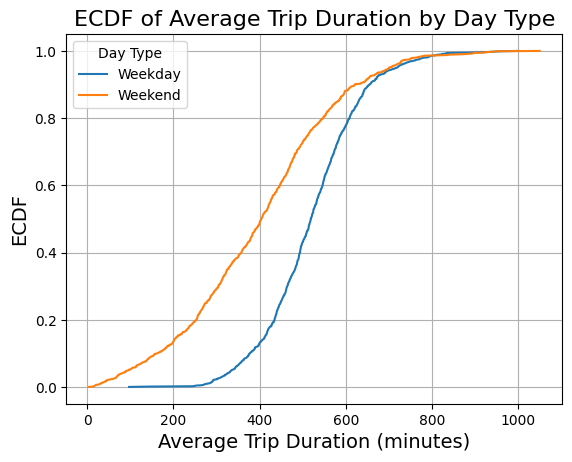

In [30]:
# Similar to your existing ecdf function
for day_type in ['Weekday', 'Weekend']:
    subset = fraction_data[fraction_data['day_type'] == day_type]
    x, y = ecdf(subset['average_trip_duration'])
    plt.plot(x, y, label=day_type)
plt.title('ECDF of Average Trip Duration by Day Type', fontsize=16)
plt.xlabel('Average Trip Duration (minutes)', fontsize=14)
plt.ylabel('ECDF', fontsize=14)
plt.legend(title='Day Type')
plt.grid(True)
plt.show()

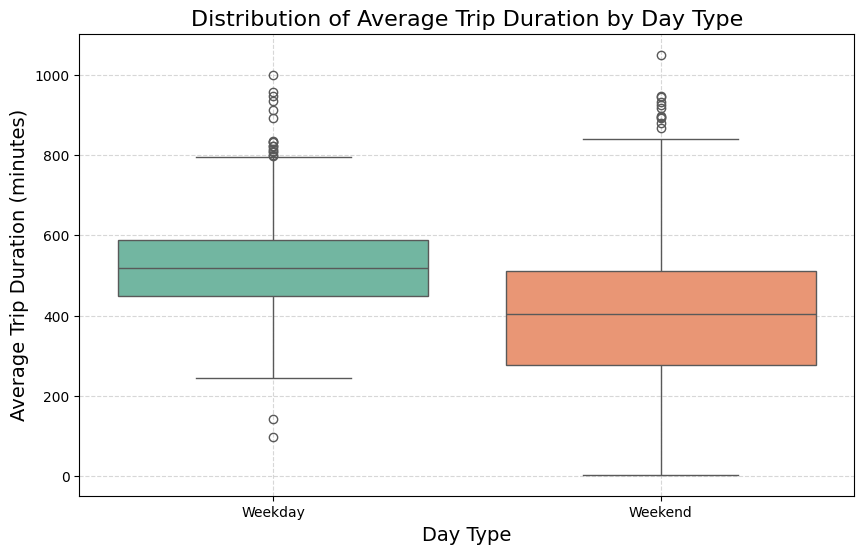

In [31]:
# plot vehicle distribution of average_trip_duration

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=fraction_data,
    x='day_type',
    y='average_trip_duration',
    hue='day_type',
    palette='Set2'
)
plt.title('Distribution of Average Trip Duration by Day Type', fontsize=16)
plt.xlabel('Day Type', fontsize=14)
plt.ylabel('Average Trip Duration (minutes)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

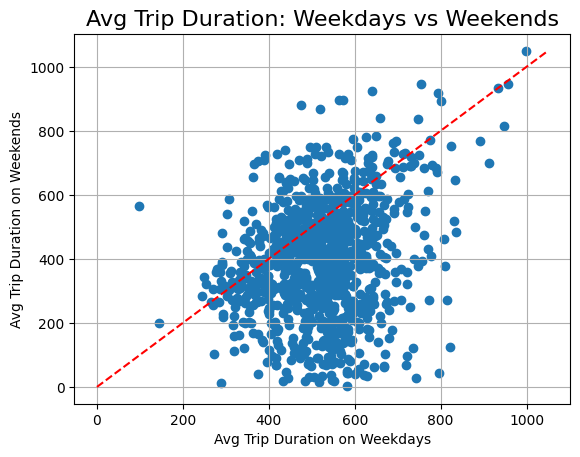

In [32]:
# Pivot to get weekday/weekend columns
pivot = fraction_data.pivot(index='vehicle_id', columns='day_type', values='average_trip_duration')

# Scatter plot
plt.scatter(pivot['Weekday'], pivot['Weekend'])
# diagonal line
max_val = max(pivot['Weekday'].max(), pivot['Weekend'].max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--')
plt.xlabel('Avg Trip Duration on Weekdays')
plt.ylabel('Avg Trip Duration on Weekends')
plt.title('Avg Trip Duration: Weekdays vs Weekends', fontsize=16)
plt.grid(True)
plt.show()

# more points below the diagonal line means vehicles tend to have longer trips on weekdays

In [33]:
fraction_data

,vehicle_id,day_type,num_trips,average_trip_duration,fraction
0,1,Weekday,357,504.097037,0.000622
1,1,Weekend,49,243.045833,0.000295
2,2,Weekday,221,659.347348,0.000385
3,2,Weekend,18,416.623333,0.000108
4,3,Weekday,288,609.226829,0.000502
...,...,...,...,...,...
1987,998,Weekend,124,272.315278,0.000746
1988,999,Weekday,1157,610.135606,0.002017
1989,999,Weekend,329,447.973529,0.001980
1990,1000,Weekday,357,436.180702,0.000622


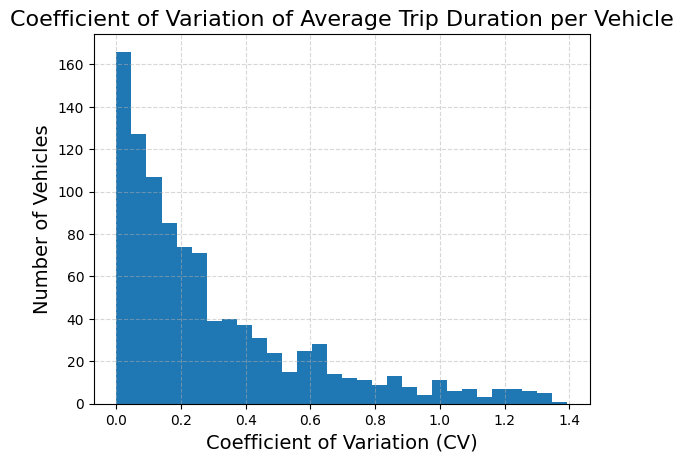

In [34]:
# vehicle consistency on weekdays and weekends
vehicle_consistency = fraction_data.groupby('vehicle_id').agg({
    'average_trip_duration': ['mean', 'std']
})
vehicle_consistency['cv'] = vehicle_consistency[('average_trip_duration', 'std')] / vehicle_consistency[('average_trip_duration', 'mean')]

# Plot CV distribution or bar chart of most/least consistent
plt.hist(vehicle_consistency['cv'], bins=30)
plt.title('Coefficient of Variation of Average Trip Duration per Vehicle', fontsize=16)
plt.xlabel('Coefficient of Variation (CV)', fontsize=14)
plt.ylabel('Number of Vehicles', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# low CV means more consistent

In [35]:
daily_data = daily_aggregation.groupby(['vehicle_id', 'date', 'day_type']).agg(
    total_distance =('total_distance', 'sum'),
    total_trip_duration =('total_trip_duration', 'sum'),
    num_trips =('num_trips', 'sum')
).reset_index()

In [36]:
daily_data

,vehicle_id,date,day_type,total_distance,total_trip_duration,num_trips
0,1,2023-09-29,Weekday,24.630,50.783333,3
1,1,2023-09-30,Weekend,11.030,67.333333,5
2,1,2023-10-01,Weekend,361.539,268.983333,1
3,1,2023-10-02,Weekday,725.195,562.733333,7
4,1,2023-10-03,Weekday,519.450,477.033333,7
...,...,...,...,...,...,...
55263,1000,2023-11-20,Weekday,12.860,252.316667,1
55264,1000,2023-11-24,Weekday,11.000,155.566667,1
55265,1000,2023-11-26,Weekend,31.580,465.433333,1
55266,1000,2023-11-27,Weekday,39.420,562.900000,2


In [37]:
statistics = daily_data.groupby('day_type').agg(
    avg_distance=('total_distance', 'mean'),
    std_distance=('total_distance', 'std'),
    min_distance=('total_distance', 'min'),
    max_distance=('total_distance', 'max'),
    avg_duration=('total_trip_duration', 'mean'),
    std_duration=('total_trip_duration', 'std'),
    min_duration=('total_trip_duration', 'min'),
    max_duration=('total_trip_duration', 'max'),
    avg_trips=('num_trips', 'mean'),
    std_trips=('num_trips', 'std'),
    min_trips=('num_trips', 'min'),
    max_trips=('num_trips', 'max')
).reset_index()

In [38]:
statistics

,day_type,avg_distance,std_distance,min_distance,max_distance,avg_duration,std_duration,min_duration,max_duration,avg_trips,std_trips,min_trips,max_trips
0,Weekday,391.018840,248.204546,0.110,2112.930,522.476173,218.753963,2.083333,1545.150000,13.826665,10.036910,1,114
1,Weekend,300.626731,220.709658,0.102,2046.935,429.423712,259.786550,2.016667,1755.883333,12.061992,10.438596,1,93


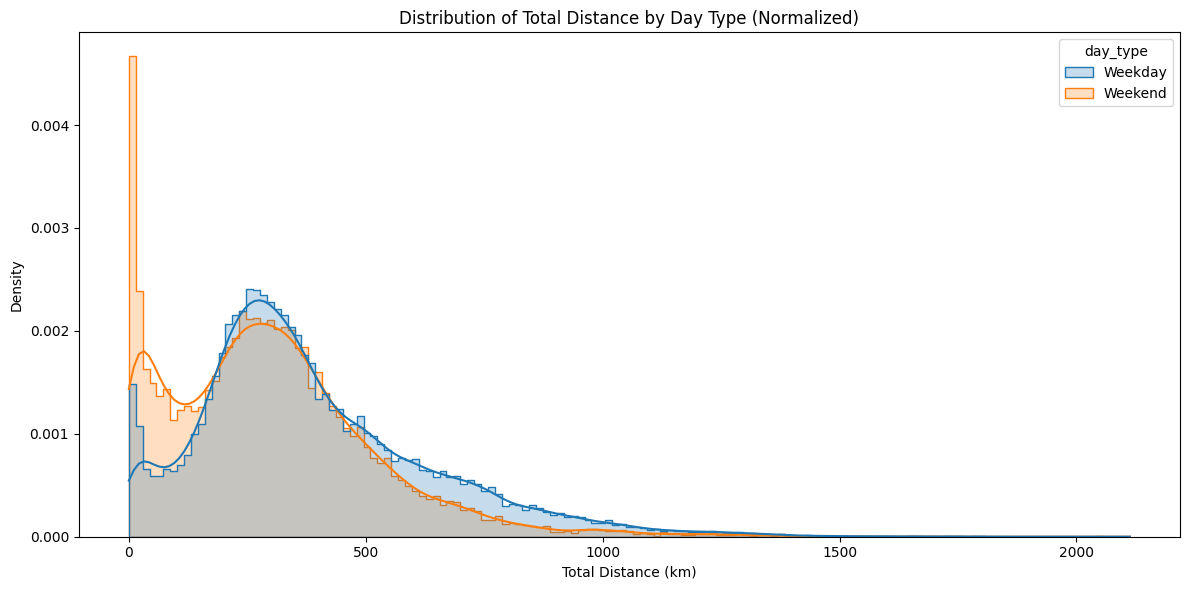

In [39]:
plt.figure(figsize=(12, 6))
sns.histplot(data=daily_data, x='total_distance', hue='day_type', kde=True, element='step', stat='density', common_norm=False)
plt.title('Distribution of Total Distance by Day Type (Normalized)')
plt.xlabel('Total Distance (km)')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

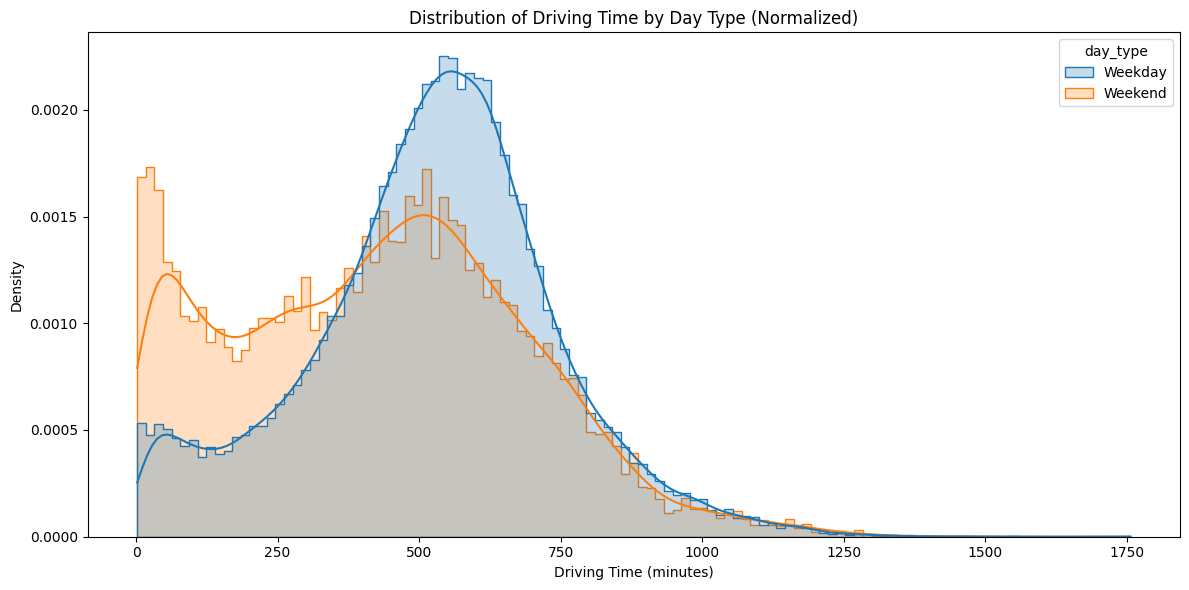

In [40]:
plt.figure(figsize=(12, 6))
sns.histplot(data=daily_data, x='total_trip_duration', hue='day_type', kde=True, element='step', stat='density', common_norm=False)
plt.title('Distribution of Driving Time by Day Type (Normalized)')
plt.xlabel('Driving Time (minutes)')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

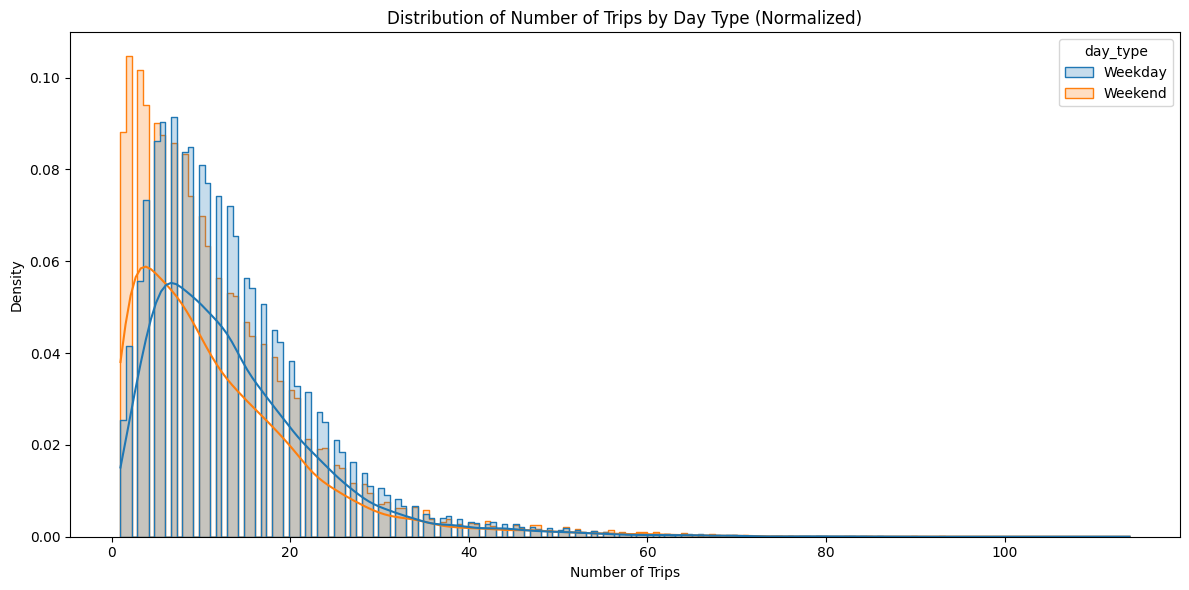

In [41]:
plt.figure(figsize=(12, 6))
sns.histplot(data=daily_data, x='num_trips', hue='day_type', kde=True, element='step', stat='density', common_norm=False)
plt.title('Distribution of Number of Trips by Day Type (Normalized)')
plt.xlabel('Number of Trips')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

**1.b.** For each vehicle, compute the fraction of its trips with different road types. Choose a
meaningful way to show the results and make comments.

In [42]:
# Add date and day_type to filtered_data (which contains road segments)
filtered_data['date'] = filtered_data['start_time'].dt.date
filtered_data['day_type'] = filtered_data['start_time'].dt.weekday.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

In [43]:
filtered_data.head()

,Unnamed: 0,vehicle_id,trip_id,start_time,stop_time,road,total_distance,trip_duration,average_speed,date,day_type
0,0,1,0,2023-09-29 13:55:35,2023-09-29 14:11:42,E,14.31,16.116667,53.274043,2023-09-29,Weekday
1,1,1,0,2023-09-29 13:55:35,2023-09-29 14:11:42,U,1.47,16.116667,5.472596,2023-09-29,Weekday
3,3,1,2,2023-09-29 15:12:03,2023-09-29 15:26:55,E,2.60,14.866667,10.493274,2023-09-29,Weekday
4,4,1,2,2023-09-29 15:12:03,2023-09-29 15:26:55,U,2.00,14.866667,8.071749,2023-09-29,Weekday
5,5,1,3,2023-09-29 15:37:38,2023-09-29 15:57:26,E,2.24,19.800000,6.787879,2023-09-29,Weekday


In [44]:
# Aggregate by vehicle, date, day_type, AND road type
# Since each row is a road segment, we can sum distance per road type
daily_aggregation_data = filtered_data.groupby(['vehicle_id', 'date', 'day_type', 'road']).agg(
    total_distance=('total_distance', 'sum'),   # sum segment distances per road type
    num_trips=('trip_id', 'nunique')    # count unique trips per road type
).reset_index()

# For trip duration and utilization, we need trip-level data (not segment-level)
trip_level_data = filtered_data.groupby(['vehicle_id', 'trip_id', 'date', 'day_type']).agg({
    'trip_duration': 'first',  # Same for all segments
    'start_time': 'first',
    'stop_time': 'first'
}).reset_index()

# Calculate daily utilization based on trip-level data
daily_utilization = trip_level_data.groupby(['vehicle_id', 'date', 'day_type']).agg(
    total_trip_duration=('trip_duration', 'sum')
).reset_index()
daily_utilization['daily_utilization'] = daily_utilization['total_trip_duration'] / (24 * 60)

# Merge utilization back to daily_aggregation_data
daily_aggregation_data = daily_aggregation_data.merge(
    daily_utilization[['vehicle_id', 'date', 'day_type', 'total_trip_duration', 'daily_utilization']], 
    on=['vehicle_id', 'date', 'day_type'], 
    how='left'
)

# compute trip counts per vehicle and road type
trip_counts = daily_aggregation_data.groupby(['vehicle_id', 'road'])['num_trips'].sum().reset_index()

# compute total trips per vehicle
total_trips = daily_aggregation_data.groupby('vehicle_id')['num_trips'].sum().reset_index()
total_trips.rename(columns={'num_trips': 'total_trips'}, inplace=True)

# merge trip counts with total trips to compute fractions
vehicle_road_fraction = pd.merge(trip_counts, total_trips, on='vehicle_id')
vehicle_road_fraction['fraction'] = vehicle_road_fraction['num_trips'] / vehicle_road_fraction['total_trips']

In [45]:
vehicle_road_fraction

,vehicle_id,road,num_trips,total_trips,fraction
0,1,A,149,703,0.211949
1,1,E,341,703,0.485064
2,1,U,213,703,0.302987
3,2,A,140,492,0.284553
4,2,E,207,492,0.420732
...,...,...,...,...,...
3182,999,E,185,1841,0.100489
3183,999,U,1482,1841,0.804997
3184,1000,A,51,767,0.066493
3185,1000,E,375,767,0.488918


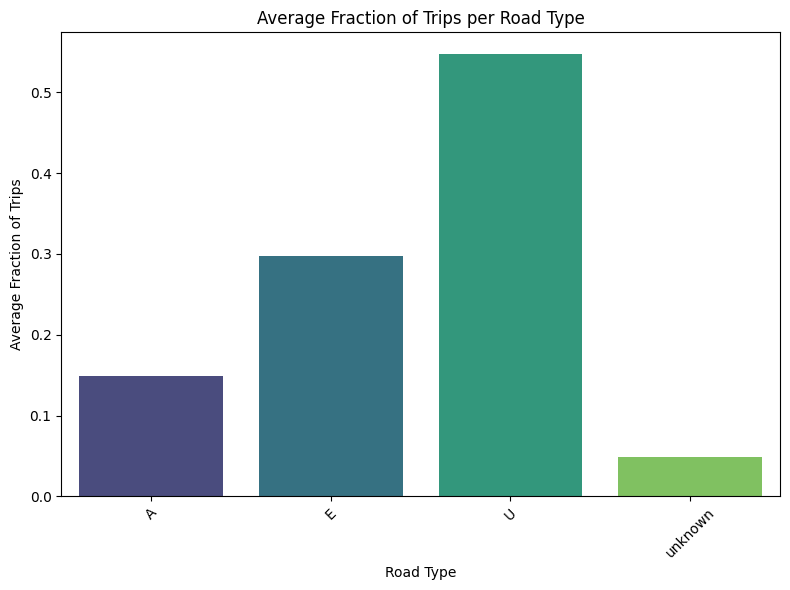

In [46]:
average_fraction = vehicle_road_fraction.groupby('road')['fraction'].mean().reset_index()   # average fraction per road type

plt.figure(figsize=(8, 6))
sns.barplot(data=average_fraction, x='road', y='fraction', hue='road', palette='viridis')
plt.title('Average Fraction of Trips per Road Type')
plt.xlabel('Road Type')
plt.ylabel('Average Fraction of Trips')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

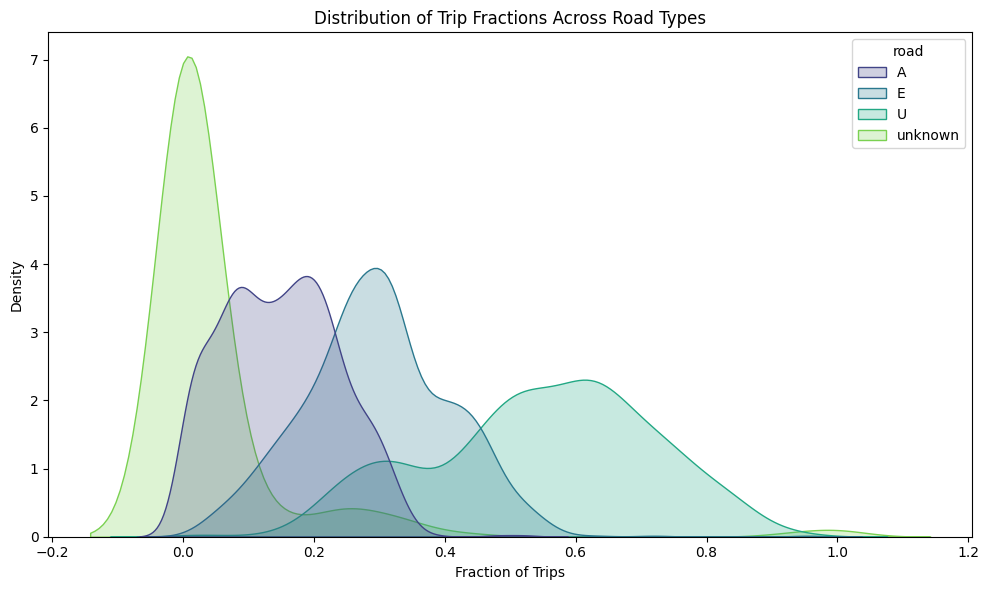

In [47]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=vehicle_road_fraction, x='fraction', hue='road', fill=True, common_norm=False, palette='viridis')
plt.title('Distribution of Trip Fractions Across Road Types')
plt.xlabel('Fraction of Trips')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

**1.c.** According to the characters you find, categorize and cluster the vehicles into 3-5 types based on their behaviours.

In [48]:
vehicle_road = daily_aggregation_data.groupby(['vehicle_id', 'road']).agg(
    total_distance=('total_distance', 'sum'),
    daily_utilization=('daily_utilization', 'mean')
).reset_index()

In [49]:
daily_aggregation_data

,vehicle_id,date,day_type,road,total_distance,num_trips,total_trip_duration,daily_utilization
0,1,2023-09-29,Weekday,E,19.150,3,50.783333,0.035266
1,1,2023-09-29,Weekday,U,5.480,3,50.783333,0.035266
2,1,2023-09-30,Weekend,E,6.130,3,67.333333,0.046759
3,1,2023-09-30,Weekend,U,4.900,4,67.333333,0.046759
4,1,2023-10-01,Weekend,A,200.989,1,268.983333,0.186794
...,...,...,...,...,...,...,...,...
148635,1000,2023-11-27,Weekday,A,12.410,1,562.900000,0.390903
148636,1000,2023-11-27,Weekday,U,18.790,2,562.900000,0.390903
148637,1000,2023-11-28,Weekday,A,20.520,1,250.683333,0.174086
148638,1000,2023-11-28,Weekday,E,48.460,2,250.683333,0.174086


In [50]:
vehicle_road

,vehicle_id,road,total_distance,daily_utilization
0,1,A,16499.866,0.351646
1,1,E,8970.230,0.311307
2,1,U,972.750,0.328262
3,2,A,25836.080,0.461543
4,2,E,6683.460,0.440680
...,...,...,...,...
3182,999,E,1252.870,0.414573
3183,999,U,11824.060,0.392321
3184,1000,A,3641.050,0.344209
3185,1000,E,7362.370,0.279580


In [51]:
# Create separate DataFrames for distance and utilization, then merge
distance_pivot = vehicle_road.pivot(
    index='vehicle_id',
    columns='road',
    values='total_distance'
).add_prefix('total_distance_road_').fillna(0)

utilization_pivot = vehicle_road.pivot(
    index='vehicle_id',
    columns='road',
    values='daily_utilization'
).add_prefix('daily_utilization_road_').fillna(0)

# Merge the two pivoted DataFrames
vehicle_data = distance_pivot.join(utilization_pivot).reset_index()

In [52]:
vehicle_data

road,vehicle_id,total_distance_road_A,total_distance_road_E,total_distance_road_U,total_distance_road_unknown,daily_utilization_road_A,daily_utilization_road_E,daily_utilization_road_U,daily_utilization_road_unknown
0,1,16499.866,8970.23,972.750,0.0,0.351646,0.311307,0.328262,0.0
1,2,25836.080,6683.46,1039.980,0.0,0.461543,0.440680,0.443563,0.0
2,3,21580.994,6933.11,1355.473,0.0,0.482764,0.419184,0.410804,0.0
3,4,133.670,6597.90,7845.640,0.0,0.307378,0.287539,0.273370,0.0
4,5,22711.820,9045.94,1299.610,0.0,0.491272,0.430032,0.411360,0.0
...,...,...,...,...,...,...,...,...,...
994,996,13113.930,4561.48,998.210,0.0,0.429407,0.341343,0.343129,0.0
995,997,13226.080,9157.01,822.770,0.0,0.431142,0.354956,0.370653,0.0
996,998,8014.040,7108.46,4922.570,0.0,0.318981,0.341079,0.283772,0.0
997,999,2541.690,1252.87,11824.060,0.0,0.411166,0.414573,0.392321,0.0


In [53]:
# normalize the features for clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
road_features = [col for col in vehicle_data.columns if 'total_distance' in col]
utilization_feature = [col for col in vehicle_data.columns if 'daily_utilization' in col]
features = road_features + utilization_feature
selected_data = vehicle_data[features]
vehicle_data[features] = scaler.fit_transform(vehicle_data[features])

In [54]:
vehicle_data

road,vehicle_id,total_distance_road_A,total_distance_road_E,total_distance_road_U,total_distance_road_unknown,daily_utilization_road_A,daily_utilization_road_E,daily_utilization_road_U,daily_utilization_road_unknown
0,1,1.042278,0.974481,-1.298045,-0.16262,-0.288883,-0.636432,-0.255493,-0.48282
1,2,2.269320,0.332318,-1.280515,-0.16262,0.961044,1.022216,1.252949,-0.48282
2,3,1.710082,0.402424,-1.198255,-0.16262,1.202395,0.746614,0.824367,-0.48282
3,4,-1.108702,0.308291,0.493961,-0.16262,-0.792356,-0.941150,-0.973635,-0.48282
4,5,1.858704,0.995741,-1.212821,-0.16262,1.299168,0.885694,0.831648,-0.48282
...,...,...,...,...,...,...,...,...,...
994,996,0.597271,-0.263570,-1.291406,-0.16262,0.595546,-0.251353,-0.060995,-0.48282
995,997,0.612010,1.026932,-1.337150,-0.16262,0.615270,-0.076822,0.299089,-0.48282
996,998,-0.072999,0.451665,-0.268187,-0.16262,-0.660389,-0.254738,-0.837553,-0.48282
997,999,-0.792220,-1.192683,1.531276,-0.16262,0.388076,0.687502,0.582570,-0.48282


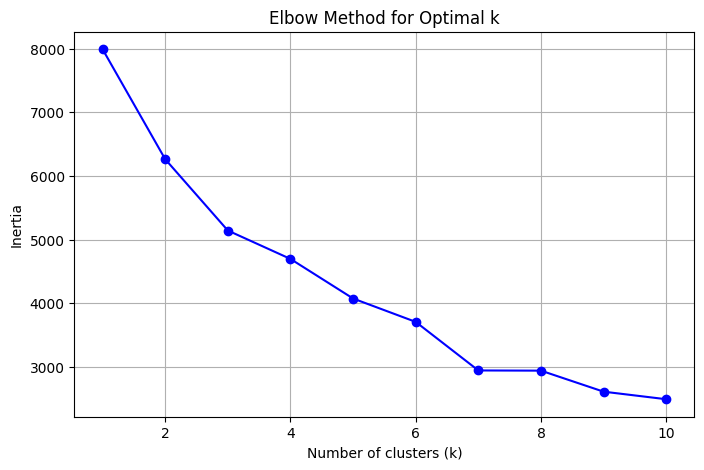

In [55]:
# use K-means to cluster vehicles based on their road usage patterns
from sklearn.cluster import KMeans

inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(vehicle_data[features])
    inertia.append(kmeans.inertia_)

# plot the elbow method
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [56]:
n_clusters = 3  # choose based on elbow method
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
vehicle_data['cluster'] = kmeans.fit_predict(vehicle_data[features])

In [57]:
vehicle_data

road,vehicle_id,total_distance_road_A,total_distance_road_E,total_distance_road_U,total_distance_road_unknown,daily_utilization_road_A,daily_utilization_road_E,daily_utilization_road_U,daily_utilization_road_unknown,cluster
0,1,1.042278,0.974481,-1.298045,-0.16262,-0.288883,-0.636432,-0.255493,-0.48282,1
1,2,2.269320,0.332318,-1.280515,-0.16262,0.961044,1.022216,1.252949,-0.48282,1
2,3,1.710082,0.402424,-1.198255,-0.16262,1.202395,0.746614,0.824367,-0.48282,1
3,4,-1.108702,0.308291,0.493961,-0.16262,-0.792356,-0.941150,-0.973635,-0.48282,0
4,5,1.858704,0.995741,-1.212821,-0.16262,1.299168,0.885694,0.831648,-0.48282,1
...,...,...,...,...,...,...,...,...,...,...
994,996,0.597271,-0.263570,-1.291406,-0.16262,0.595546,-0.251353,-0.060995,-0.48282,1
995,997,0.612010,1.026932,-1.337150,-0.16262,0.615270,-0.076822,0.299089,-0.48282,1
996,998,-0.072999,0.451665,-0.268187,-0.16262,-0.660389,-0.254738,-0.837553,-0.48282,0
997,999,-0.792220,-1.192683,1.531276,-0.16262,0.388076,0.687502,0.582570,-0.48282,2


In [58]:
clusters = vehicle_data.groupby('cluster')[features].mean()

In [59]:
clusters

road,total_distance_road_A,total_distance_road_E,total_distance_road_U,total_distance_road_unknown,daily_utilization_road_A,daily_utilization_road_E,daily_utilization_road_U,daily_utilization_road_unknown
cluster,,,,,,,,
0,-0.214617,0.124346,-0.242224,-0.079716,-0.752979,-0.803476,-0.819914,-0.195736
1,1.118185,0.441160,-0.962888,0.322610,0.417101,0.333169,0.405036,0.721941
2,-0.619912,-0.509376,1.074814,-0.156307,0.621270,0.752183,0.715690,-0.327808


In [60]:
# rescale back the cluster centers to original scale
clusters_rescaled = pd.DataFrame(scaler.inverse_transform(clusters), columns=features)
clusters_rescaled

,total_distance_road_A,total_distance_road_E,total_distance_road_U,total_distance_road_unknown,daily_utilization_road_A,daily_utilization_road_E,daily_utilization_road_U,daily_utilization_road_unknown
0,6936.505637,5942.865257,5022.143370,178.609232,0.310841,0.298278,0.285120,0.053856
1,17077.420973,7071.052096,2258.179515,1045.384327,0.413718,0.386935,0.378751,0.226008
2,3852.732445,3686.152785,10073.390123,13.599387,0.431669,0.419618,0.402497,0.029080


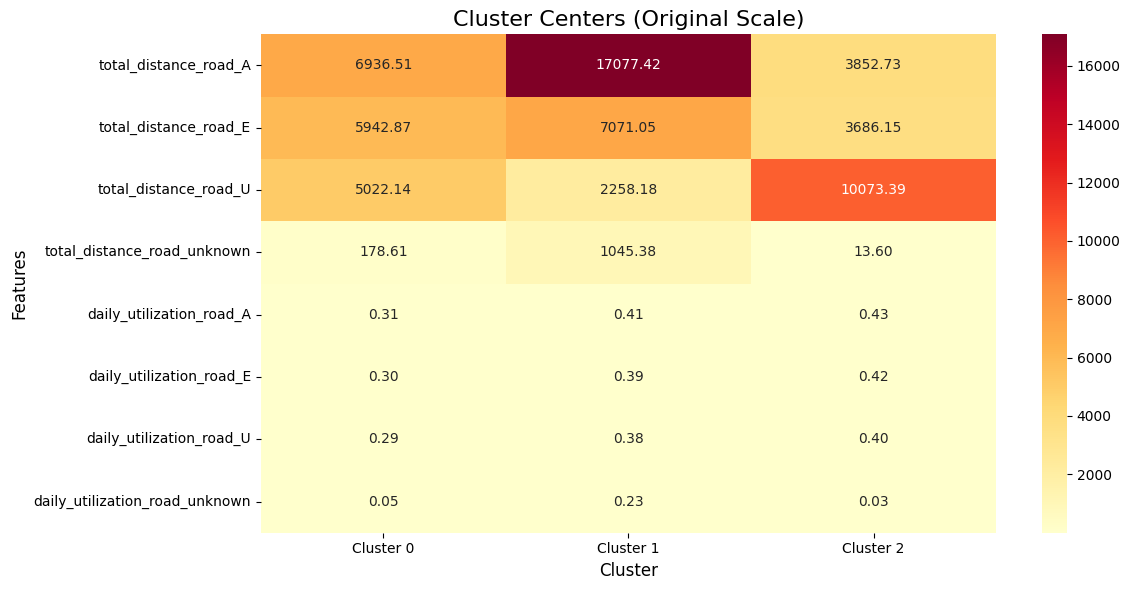

In [61]:
plt.figure(figsize=(12, 6))
sns.heatmap(clusters_rescaled.T, annot=True, fmt='.2f', cmap='YlOrRd', 
            xticklabels=[f'Cluster {i}' for i in range(n_clusters)],
            yticklabels=features)
plt.title('Cluster Centers (Original Scale)', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

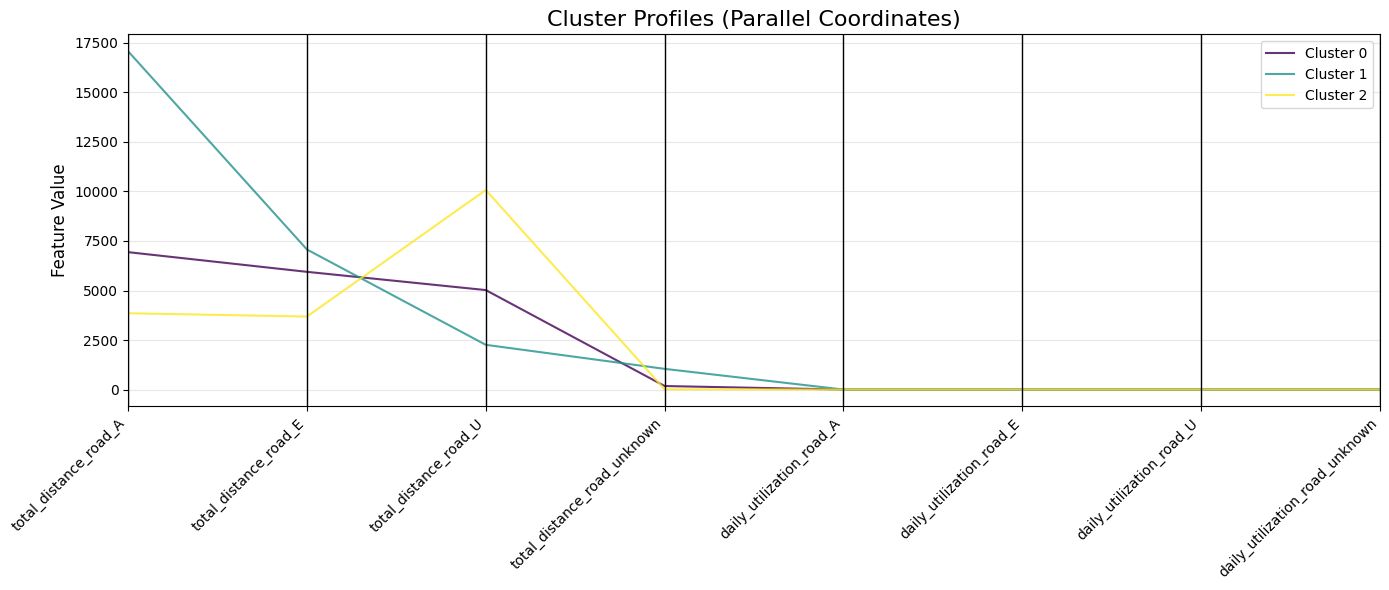

In [62]:
from pandas.plotting import parallel_coordinates

# Prepare data for parallel coordinates
cluster_viz = clusters_rescaled.copy()
cluster_viz['cluster'] = [f'Cluster {i}' for i in range(n_clusters)]

plt.figure(figsize=(14, 6))
parallel_coordinates(cluster_viz, 'cluster', colormap='viridis', alpha=0.8)
plt.title('Cluster Profiles (Parallel Coordinates)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Feature Value', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

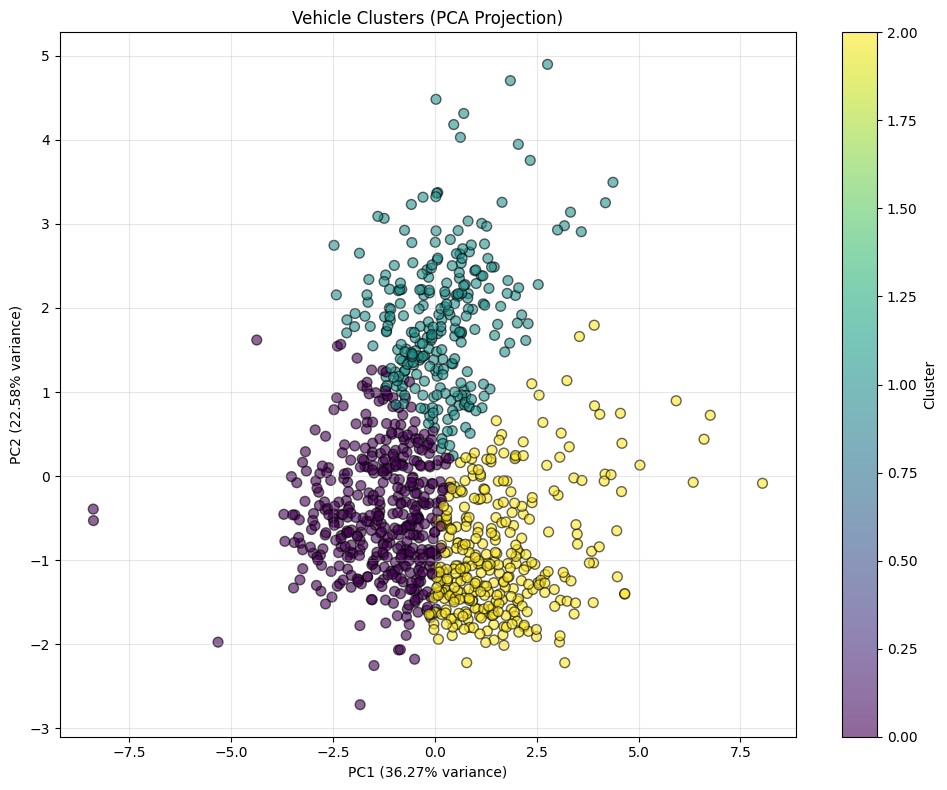

Total variance explained: 58.85%


In [63]:
from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
vehicle_data_pca = pca.fit_transform(vehicle_data[features])

# Create scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(vehicle_data_pca[:, 0], vehicle_data_pca[:, 1], 
                     c=vehicle_data['cluster'], cmap='viridis', 
                     s=50, alpha=0.6, edgecolors='k')
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Vehicle Clusters (PCA Projection)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

**2.** Choose at least three EV model from the EV database. Choose and define the evaluation metrics that you want to monitor. The mandatory one is the percentage of feasible trips.

In [64]:
cars = {
    # A - mini
    "Renault Twing E-Tech 27.5 kWh": {
        "Battery_Capacity": "27.5 kWh",
        "AC": {
            "Charge Power": "6.6 kW",
            "Charge Time (0->185 km)": "5h",
            "Charge Speed": "38 km/h"
        },
        "DC": {
            "Charge Power (max)": "50 kW",
            "Charge Power (10-80%)": "40 kW",
            "Charge Time (18->148 km)": "30 min",
            "Charge Speed": "250 km/h"
        },
        "Energy_Consumption_Rate": {
            "City - Mild Weather": "96 Wh/km",
            "Highway - Mild Weather": "162 Wh/km",
            "Combined - Mild Weather": "128 Wh/km"
        }
    },
    # B - compact
    "Fiat 500e Hatchback 42 kWh": {
        "Battery_Capacity": "37.3 kWh",
        "AC": {
            "Charge Power": "11 kW",
            "Charge Time (0->235 km)": "4h",
            "Charge Speed": "59 km/h"
        },
        "DC": {
            "Charge Power (max)": "85 kW",
            "Charge Power (10-80%)": "67 kW",
            "Charge Time (23->188 km)": "25 min",
            "Charge Speed": "390 km/h"
        },
        "Energy_Consumption_Rate": {
            "City - Mild Weather": "105 Wh/km",
            "Highway - Mild Weather": "173 Wh/km",
            "Combined - Mild Weather": "138 Wh/km"
        }
    },
    # C - medium
    "CUPRA Born 170 kW - 77 kWh": {
        "Battery_Capacity": "77.0 kWh",
        "AC": {
            "Charge Power": "11 kW",
            "Charge Time (0->450 km)": "8h 15m",
            "Charge Speed": "55 km/h"
        },
        "DC": {
            "Charge Power (max)": "175 kW",
            "Charge Power (10-80%)": "115 kW",
            "Charge Time (0->450 km)": "30 min",
            "Charge Speed": "630 km/h"
        },
        "Energy_Consumption_Rate": {
            "City - Mild Weather": "118 Wh/km",
            "Highway - Mild Weather": "186 Wh/km",
            "Combined - Mild Weather": "150 Wh/km"
        }
    },
    # D - large
    "BYD SEAL 82.5 kWh RWD Design": {
        "Battery_Capacity": "82.5 kWh",
        "AC": {
            "Charge Power": "11 kW",
            "Charge Time (0->480 km)": "9h",
            "Charge Speed": "54 km/h"
        },
        "DC": {
            "Charge Power (max)": "150 kW",
            "Charge Power (10-80%)": "100 kW",
            "Charge Time (48->384 km)": "36 min",
            "Charge Speed": "560 km/h"
        },
        "Energy_Consumption_Rate": {
            "City - Mild Weather": "121 Wh/km",
            "Highway - Mild Weather": "181 Wh/km",
            "Combined - Mild Weather": "149 Wh/km"
        }
    },
    # E - executive
    "BMW iX xDrive40": {
        "Battery_Capacity": "71.0 kWh",
        "AC": {
            "Charge Power": "11 kW",
            "Charge Time (0->480 km)": "7h 45m",
            "Charge Speed": "47 km/h"
        },
        "DC": {
            "Charge Power (max)": "148 kW",
            "Charge Power (10-80%)": "102 kW",
            "Charge Time (36->288 km)": "31 min",
            "Charge Speed": "480 km/h"
        },
        "Energy_Consumption_Rate": {
            "City - Mild Weather": "138 Wh/km",
            "Highway - Mild Weather": "215 Wh/km",
            "Combined - Mild Weather": "175 Wh/km"
        }
    },
    # F - luxury
    "Lotus Eletre S": {
        "Battery_Capacity": "109.0 kWh",
        "AC": {
            "Charge Power": "22 kW",
            "Charge Time (0->480 km)": "6h",
            "Charge Speed": "82 km/h"
        },
        "DC": {
            "Charge Power (max)": "367 kW",
            "Charge Power (10-80%)": "259 kW",
            "Charge Time (48->384 km)": "19 min",
            "Charge Speed": "1060 km/h"
        },
        "Energy_Consumption_Rate": {
            "City - Mild Weather": "156 Wh/km",
            "Highway - Mild Weather": "242 Wh/km",
            "Combined - Mild Weather": "196 Wh/km"
        }
    },
    # N - passanger van
    "Volkswagen ID. Buzz Pro": {
        "Battery_Capacity": "77.0 kWh",
        "AC": {
            "Charge Power": "11 kW",
            "Charge Time (0->405 km)": "8h 15m",
            "Charge Speed": "42 km/h"
        },
        "DC": {
            "Charge Power (max)": "175 kW",
            "Charge Power (10-80%)": "115 kW",
            "Charge Time (34->276 km)": "30 min",
            "Charge Speed": "480 km/h"
        },
        "Energy_Consumption_Rate": {
            "City - Mild Weather": "154 Wh/km",
            "Highway - Mild Weather": "252 Wh/km",
            "Combined - Mild Weather": "200 Wh/km"
        }
    },
    # S - sport
    "Audi e-tron GT RS": {
        "Battery_Capacity": "85.0 kWh",
        "AC": {
            "Charge Power": "11 kW",
            "Charge Time (0->405 km)": "9h 15m",
            "Charge Speed": "45 km/h"
        },
        "DC": {
            "Charge Power (max)": "268 kW",
            "Charge Power (10-80%)": "216 kW",
            "Charge Time (40->324 km)": "17 min",
            "Charge Speed": "1000 km/h"
        },
        "Energy_Consumption_Rate": {
            "City - Mild Weather": "150 Wh/km",
            "Highway - Mild Weather": "227 Wh/km",
            "Combined - Mild Weather": "185 Wh/km"
        }
    }
}

performance_metrics = {
    "feasibility_metrics": {
        "total_trips": 0,  # Total number of trips,
        "feasible_trips": 0,  # Number of trips completed successfully without running out of battery
        "unfeasible_trips": 0,  # Number of trips needing intervention (out of battery)
        "feasible_trips_percentage": 0.0  # % of trips completed successfully without running out of battery
    },
    "battery_performance_metrics": {
        "avg_soc": 0.0,  # Average State of Charge
        "min_soc": 100.0,  # Minimum SoC reached
        "soc_below_20_count": 0,  # Times battery dropped below 20%
    },
    "charging_behavior_metrics": {
        "total_charging_events": 0,  # Number of charging sessions
        "total_charging_time": 0.0,  # Hours spent charging
        "avg_charging_duration": 0.0,  # Average time per charge
        "fast_charging": 0.0,  # number of fast charging sessions
        "slow_charging": 0.0,  # number of slow charging sessions
        "fast_charging_ratio": 0.0,  # % of fast vs slow charging
        "fast_charging_SoC_threshold": 20.0,  # % SoC - if below this, use fast charging
        "fast_charging_time_threshold": 2  # hours - if parking time < this and SoC < 80%, use fast charging
    },
    "energy_efficiency_metrics": {
        "total_energy_consumed": 0.0,  # kWh consumed
        "avg_energy_per_km": 0.0,  # Wh/km actual consumption
        "total_distance_covered": 0.0  # km successfully driven
    }
}

**3.** Implement the replicator of trips and simulator of EV. Report it with diagram and/or pseudocode.

## Pseudocode for Vehicle Battery Simulation

### Data Preprocessing:

1. Load the dataset (Unipol_dataset_lab3.csv).
2. Sort the data by `vehicle_id` and `start_time`.

### Initialization:

1. Define EV parameters for each model:
    - Battery capacity (kWh)
    - Energy consumption rate (Wh/km)
    - Slow (AC) charging power (kW)
    - Fast (DC) charging power (kW)
2. Initialize metrics dictionary for each vehicle:
    - **Feasibility Metrics:**
        - Total trips count
        - Feasible trips count
        - Unfeasible trips count
        - Feasible trips percentage (mandatory)
    - **Battery Performance Metrics:**
        - Average SoC across all trips
        - Minimum SoC reached
        - Count of SoC below 20%
    - **Charging Metrics:**
        - Total charging events
        - Total charging time (hours)
        - Average charging duration (hours)
        - Slow charging events count
        - Fast charging events count
        - Fast charging ratio (%)
        - Fast charging threshold
    - **Energy & Efficiency Metrics:**
        - Total energy consumed (kWh)
        - Average energy per km (Wh/km)
        - Total distance covered (km)
3. Create data structures for:
    - SoC tracking per trip
    - Charging events log
    - Unfeasible trips details

### Simulation Loop:

**For each EV model:**
1. Initialize results DataFrame to store trip-level data
2. **For each `vehicle_id`:**
    1. Initialize SoC to 100% of the battery capacity
    2. **For each trip in chronological order:**
        1. **Calculate energy required:**
            - `energy_needed = total_distance * energy_consumption_rate`
        2. **Check trip feasibility:**
            - If `current_SoC >= energy_needed`:
                - Deduct energy: `new_SoC = current_SoC - energy_needed`
                - Record trip as **feasible**
                - Update metrics:
                    - Increment feasible_trips count
                    - Add energy_needed to total_energy_consumed
                    - Add distance to total_distance_covered
                    - If `new_SoC < 20% of battery_capacity`:
                        - Increment soc_below_20_count
            - Else:
                - Record trip as **unfeasible**
                - Increment unfeasible_trips count
                - Log unfeasible trip details
        3. **Calculate parking duration until next trip:**
            - get the next trip of the vehicle, if exists, else skip to next vehicle
            - `parking_time = next_trip_start_time - current_trip_end_time`
        4. **Charging logic (if parking time > 0):**
            1. Determine charging type:
                - If `current_SoC < fast_charging_SoC_threshold * battery_capacity`:
                    - Use fast charging power
                    - Increment fast_charging count
                    - `charging_power = fast_charging_power (DC)`
                - Elif `parking_time < fast_charging_time_threshold` and `current_SoC < 80%`:
                    - Use fast charging power
                    - Increment fast_charging count
                    - `charging_power = fast_charging_power (DC)`
                - Else:
                    - Use slow charging power
                    - Increment slow_charging count
                    - `charging_power = slow_charging_power (AC)`
            2. Calculate energy recharged:
                - `energy_needed_to_full = battery_capacity - current_SoC`
                - `time_to_full = energy_needed_to_full / charging_power`
                - `actual_charging_time = min(parking_time, time_to_full)`
                - `energy_recharged = charging_power * actual_charging_time`
                - `new_SoC = min(current_SoC + energy_recharged, battery_capacity)`
            3. Update charging metrics:
                - Increment total_charging_events
                - Add `actual_charging_time` to total_charging_time
        5. **Store trip results:**
            - Trip ID, SoC before, SoC after, feasibility, energy consumed
3. **Aggregate vehicle-level metrics:**
    - Calculate percentages and averages from accumulated counts

### Metrics Calculation:

**For each EV model, calculate:**

1. **Feasibility:**
    - `feasible_trips_percentage = (feasible_trips / total_trips) * 100`
2. **Battery Performance:**
    - `avg_soc = mean(all_SoC_values)`
    - `min_soc = min(all_SoC_values)`
3. **Charging:**
    - `avg_charging_duration = total_charging_time / total_charging_events`
    - `fast_charging_ratio = (fast_charging / total_charging_events) * 100`
4. **Energy Efficiency:**
    - `avg_energy_per_km = (total_energy_consumed * 1000) / total_distance_covered` (Wh/km)

### Comparison & Analysis:

1. Create comparison DataFrame with all EV models and their metrics
2. Identify best-performing EV for each metric category
3. Analyze trade-offs (e.g., range vs charging speed vs cost)

### Visualization:

1. **Feasibility Comparison:**
    - Bar chart: Feasible trips percentage per EV model
    - Bar chart: Unfeasible trips count per EV model
2. **Battery SoC Over Time:**
    - Line plot: SoC evolution for sample vehicles from each model
    - Distribution plot: SoC distribution across all trips
3. **Charging Analysis:**
    - Bar chart: Total charging events per EV model
    - Pie chart: Fast vs Slow charging ratio per model
    - Histogram: Charging duration distribution
4. **Energy Efficiency:**
    - Bar chart: Average energy consumption (Wh/km) per model
    - Scatter plot: Energy consumption vs distance per trip
5. **Comprehensive Dashboard:**

    - Heatmap: All metrics normalized across EV models
    - Radar chart: Multi-metric comparison of EV models

4. conduct the simulation of all the vehicles, with different parameters(types of EV and charging power) and analyse the result 

In [65]:
# prepare data

df = pd.read_csv('Unipol_dataset_lab3.csv')

# Convert timestamps
df['start_time'] = pd.to_datetime(df['start_time'])
df['stop_time'] = pd.to_datetime(df['stop_time'])

# Aggregate telemetry rows into one row per trip
trips = (
    df.groupby(['vehicle_id', 'trip_id'], as_index=False)
      .agg(
          trip_start=('start_time', 'min'),
          trip_end=('stop_time', 'max'),
          trip_distance=('total_distance', 'sum')
      )
)

# Compute trip duration
trips['trip_duration_min'] = (
    (trips['trip_end'] - trips['trip_start'])
    .dt.total_seconds() / 60
)

# Sort trips chronologically for simulation
trips = trips.sort_values(['vehicle_id', 'trip_start'])
                          
# Sort chronologically 
ordered_trips = trips.copy()


print(f"Data Loaded: {len(ordered_trips)} rows ready for simulation.")

Data Loaded: 966000 rows ready for simulation.


In [66]:
ordered_trips.head()

,vehicle_id,trip_id,trip_start,trip_end,trip_distance,trip_duration_min
0,1,0,2023-09-29 13:55:35,2023-09-29 14:11:42,15.78,16.116667
1,1,1,2023-09-29 14:32:24,2023-09-29 14:34:31,0.03,2.116667
2,1,2,2023-09-29 15:12:03,2023-09-29 15:26:55,4.60,14.866667
3,1,3,2023-09-29 15:37:38,2023-09-29 15:57:26,4.25,19.800000
4,1,4,2023-09-29 16:13:55,2023-09-29 16:13:58,0.00,0.050000


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi


# Global Thresholds
FAST_CHARGING_SOC_THRESHOLD = 0.20  # < 20% SoC
FAST_CHARGING_TIME_THRESHOLD = 2.0  # < 2 Hours

cars_config = {
    "Renault Twingo (27kWh)": {
        "capacity": 27.5, "ac_power": 6.6, "dc_power": 50.0,
        "consumption": {"U": 0.096, "A": 0.162, "E": 0.128, "_": 0.128}
    },
    "Fiat 500e (37kWh)": {
        "capacity": 37.3, "ac_power": 11.0, "dc_power": 85.0,
        "consumption": {"U": 0.105, "A": 0.173, "E": 0.138, "_": 0.138}
    },
    "CUPRA Born (77kWh)": {
        "capacity": 77.0, "ac_power": 11.0, "dc_power": 175.0,
        "consumption": {"U": 0.118, "A": 0.186, "E": 0.150, "_": 0.150}
    },
    "BYD SEAL (82.5kWh)": {
        "capacity": 82.5, "ac_power": 11.0, "dc_power": 150.0,
        "consumption": {"U": 0.121, "A": 0.181, "E": 0.149, "_": 0.149}
    },
    "BMW iX (71kWh)": {
        "capacity": 71.0, "ac_power": 11.0, "dc_power": 148.0,
        "consumption": {"U": 0.138, "A": 0.215, "E": 0.175, "_": 0.175}
    },
    "Lotus Eletre (109kWh)": {
        "capacity": 109.0, "ac_power": 22.0, "dc_power": 367.0,
        "consumption": {"U": 0.156, "A": 0.242, "E": 0.196, "_": 0.196}
    },
    "VW ID.Buzz (77kWh)": {
        "capacity": 77.0, "ac_power": 11.0, "dc_power": 175.0,
        "consumption": {"U": 0.154, "A": 0.252, "E": 0.200, "_": 0.200}
    },
    "Audi e-tron GT (85kWh)": {
        "capacity": 85.0, "ac_power": 11.0, "dc_power": 268.0,
        "consumption": {"U": 0.150, "A": 0.227, "E": 0.185, "_": 0.185}
    }
}

def init_metrics_structure():
    """Initializes the exact metrics dictionary from Pseudocode"""
    return {
        "feasibility": {
            "total_trips": 0, "feasible_trips": 0, "unfeasible_trips": 0
        },
        "battery_perf": {
            "soc_values": [], "soc_below_20_count": 0
        },
        "charging": {
            "total_events": 0, "total_time_hours": 0.0,
            "slow_events": 0, "fast_events": 0,
            "durations": []
        },
        "energy": {
            "total_consumed_kwh": 0.0, "total_distance_km": 0.0
        }
    }

# ==============================================================================
# SIMULATION LOOP
# ==============================================================================
def run_simulation(trips_df, car_name, car_params):
    print(f"Simulating: {car_name}...")
    
    # Initialize Data
    trips = trips_df.sort_values(by=['vehicle_id', 'trip_start']).copy()
    trip_log = [] # To store detailed trip results
    
    # Global metrics for this car model
    model_metrics = init_metrics_structure()

    # Vehicle Loop
    for vid, vehicle_trips in trips.groupby('vehicle_id'):
        
        # Initialize SoC
        battery_cap = car_params['capacity']
        current_soc = battery_cap
        
        trip_list = vehicle_trips.to_dict('records')
        
        # Trip Loop
        for i, trip in enumerate(trip_list):
            
            # --- Calculate Energy Required ---
            dist = trip['trip_distance']
            # road = trip['road'] if trip['road'] in ['U', 'A', 'E'] else '_'
            consumption_rate = car_params['consumption']['_']


            # how much energy is needed for this trip
            energy_needed = dist * consumption_rate
            
            # Tracking "SoC Before" for logging
            soc_before = current_soc
            status = "Feasible"
            vehicle_unfeasible = 0

            # --- Check Feasibility ---
            model_metrics['feasibility']['total_trips'] += 1
            
            if current_soc - energy_needed > 0:
                # Feasible
                current_soc -= energy_needed
                status = "Feasible"
                # Update Metrics
                model_metrics['feasibility']['feasible_trips'] += 1
                model_metrics['energy']['total_consumed_kwh'] += energy_needed
                model_metrics['energy']['total_distance_km'] += dist
                model_metrics['battery_perf']['soc_values'].append(current_soc / battery_cap * 100)
                
                if (current_soc / battery_cap) < 0.20:
                    model_metrics['battery_perf']['soc_below_20_count'] += 1
            else:
                # Unfeasible
                status = "Unfeasible"
                model_metrics['feasibility']['unfeasible_trips'] += 1
                # current_soc = battery_cap * 0.20  #reset the battery to 20% after unfeasible trip
                current_soc = 0  # battery depleted
                vehicle_unfeasible += 1
            soc_after = current_soc

            # --- Calculate Parking Duration ---
            parking_time = 0
            charge_type = "None"
            energy_recharged = 0
            
            if i < len(trip_list) - 1:
                next_start = trip_list[i+1]['trip_start']
                current_end = trip['trip_end']
                parking_time = max(0, (next_start - current_end).total_seconds() / 3600)
                
                # --- Charging Logic ---
                if parking_time > 0:
                    power = 0
                    
                    # Determine Charging Type
                    is_low_soc = current_soc < (FAST_CHARGING_SOC_THRESHOLD * battery_cap)
                    is_short_stop = (parking_time < FAST_CHARGING_TIME_THRESHOLD) and (current_soc < (battery_cap * 0.8))
                    
                    if is_low_soc or is_short_stop:
                        # Fast Charging
                        power = car_params['dc_power']
                        charge_type = "Fast (DC)"
                        model_metrics['charging']['fast_events'] += 1
                    else:
                        # Slow Charging
                        power = car_params['ac_power']
                        charge_type = "Slow (AC)"
                        model_metrics['charging']['slow_events'] += 1
                    
                    # Calculate Energy Recharged
                    energy_needed_to_full = battery_cap - current_soc
                    time_to_full = energy_needed_to_full / power if power > 0 else 0
                    actual_charging_time = min(parking_time, time_to_full)
                    
                    # Update Battery
                    energy_recharged = power * actual_charging_time
                    current_soc = min(current_soc + energy_recharged, battery_cap) # Cap at 100% => gets the soc and do not exceed capacity
                    
                    # Update Charging Metrics
                    model_metrics['charging']['total_events'] += 1
                    model_metrics['charging']['total_time_hours'] += actual_charging_time
                    model_metrics['charging']['durations'].append(actual_charging_time)

            # --- Store Trip Results ---
            trip_log.append({
                'car_model': car_name,
                'vehicle_id': vid,
                'trip_id': trip.get('trip_id', i), # Safety get
                'soc_before': (soc_before / battery_cap) * 100,
                'soc_after': (soc_after / battery_cap) * 100,
                'status': status,
                'energy_consumed': energy_needed,
                'parking_time': parking_time,
                'charge_type': charge_type,
                'energy_recharged': energy_recharged
            })

    return pd.DataFrame(trip_log), model_metrics

# ==============================================================================
# EXECUTION & METRICS AGGREGATION
# ==============================================================================
all_trip_logs = []
model_summaries = []

for model_name, params in cars_config.items():
    
    # Run Simulation
    df_log, raw_metrics = run_simulation(ordered_trips, model_name, params)
    all_trip_logs.append(df_log)
    
    # Metrics Calculation (Aggregating the accumulated counts)
    f_metrics = raw_metrics['feasibility']
    b_metrics = raw_metrics['battery_perf']
    c_metrics = raw_metrics['charging']
    e_metrics = raw_metrics['energy']
    
    # Calculations
    total_trips = f_metrics['total_trips']
    feasible_pct = (f_metrics['feasible_trips'] / total_trips * 100) if total_trips > 0 else 0
    
    avg_soc = np.mean(b_metrics['soc_values']) if b_metrics['soc_values'] else 0
    min_soc = np.min(b_metrics['soc_values']) if b_metrics['soc_values'] else 0
    
    avg_charge_duration = (c_metrics['total_time_hours'] / c_metrics['total_events']) if c_metrics['total_events'] > 0 else 0
    fast_ratio = (c_metrics['fast_events'] / c_metrics['total_events'] * 100) if c_metrics['total_events'] > 0 else 0
    
    avg_energy_km = (e_metrics['total_consumed_kwh'] * 1000) / e_metrics['total_distance_km'] if e_metrics['total_distance_km'] > 0 else 0
    
    # Store Summary
    model_summaries.append({
        'Car Model': model_name,
        'Feasibility %': feasible_pct,
        'Unfeasible Trips': f_metrics['unfeasible_trips'],
        'Avg SoC (%)': avg_soc,
        'Min SoC (%)': min_soc,
        'SoC < 20% Count': b_metrics['soc_below_20_count'],
        'Total Charging Events': c_metrics['total_events'],
        'Avg Charge Duration (h)': avg_charge_duration,
        'Fast Charge Ratio (%)': fast_ratio,
        'Efficiency (Wh/km)': avg_energy_km,
        'Total Energy (kWh)': e_metrics['total_consumed_kwh']
    })

# Create Final DataFrames
final_trip_data = pd.concat(all_trip_logs)
comparison_df = pd.DataFrame(model_summaries)

print("\n--- Simulation Complete. Comparison Table Created. ---")
print(comparison_df[['Car Model', 'Feasibility %', 'Efficiency (Wh/km)', 'Fast Charge Ratio (%)']])



Simulating: Renault Twingo (27kWh)...
Simulating: Fiat 500e (37kWh)...
Simulating: CUPRA Born (77kWh)...
Simulating: BYD SEAL (82.5kWh)...
Simulating: BMW iX (71kWh)...
Simulating: Lotus Eletre (109kWh)...
Simulating: VW ID.Buzz (77kWh)...
Simulating: Audi e-tron GT (85kWh)...

--- Simulation Complete. Comparison Table Created. ---
                Car Model  Feasibility %  Efficiency (Wh/km)  \
0  Renault Twingo (27kWh)      96.884783               128.0   
1       Fiat 500e (37kWh)      98.374120               138.0   
2      CUPRA Born (77kWh)      99.816563               150.0   
3      BYD SEAL (82.5kWh)      99.835714               149.0   
4          BMW iX (71kWh)      99.560559               175.0   
5   Lotus Eletre (109kWh)      99.884886               196.0   
6      VW ID.Buzz (77kWh)      99.489234               200.0   
7  Audi e-tron GT (85kWh)      99.764493               185.0   

   Fast Charge Ratio (%)  
0              30.572714  
1              21.979884  
2       

1. **Feasibility:**

- Feasibility => Lotus Eletre (99.86%) and BYD SEAL (99.82%) are nearly perfect, their large batteries allow them to handle almost any trip in the simulation 

- Renault Twingo (97.41%) and Fiat 500e (98.48%) => lower performance but still high 

###### ------------------------------------------------------------------------------------------------------------------------------------------------------
######
2. **Battery Performance:**
- Avg SOC : avg battery level maintained during operation 
- Larger batteries maintain a higher "buffer." The Lotus Eletre sits comfortably at 90.1%, whereas the Twingo drops to 78.0%. This indicates the smaller cars are being pushed closer to their limits more frequently.
- Every single model hit a Minimum SoC of 0.0%.

###### ------------------------------------------------------------------------------------------------------------------------------------------------------
######
3. **Charging:**
- Fast Charge Ratio: The percentage of charging sessions that used high-power (DC) fast chargers rather than slow (AC) chargers.

- Small Batteries = More Stress: The Renault Twingo has the highest ratio at 28.0%. Because its range is short, it frequently needs "emergency" fast top-ups to keep working.

Large Batteries = More Flexibility: The Lotus Eletre has the lowest ratio (8.4%). It can likely complete its daily duties on a single charge and recharge slowly overnight.
###### ------------------------------------------------------------------------------------------------------------------------------------------------------
######
4. **Energy Efficiency:**

- How much energy is used per kilometer (Wh/km). Lower is better.
- Most Efficient: The Renault Twingo (125.8 Wh/km) is the most economical to run per kilometer, followed by the Fiat 500e.
- The VW ID.Buzz (204.5 Wh/km) and Lotus Eletre (202.8 Wh/km) are the heaviest consumers.

In [68]:
df = pd.DataFrame(model_summaries)

sns.set_theme(style="whitegrid")



1. **Feasibility Comparison:**
    - Bar chart: Feasible trips percentage per EV model
    - Bar chart: Unfeasible trips count per EV model



/tmp/ipykernel_6384/902789227.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, y='Car Model', x='Feasibility %', ax=axes[0], palette='viridis')
/tmp/ipykernel_6384/902789227.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, y='Car Model', x='Unfeasible Trips', ax=axes[1], palette='magma')


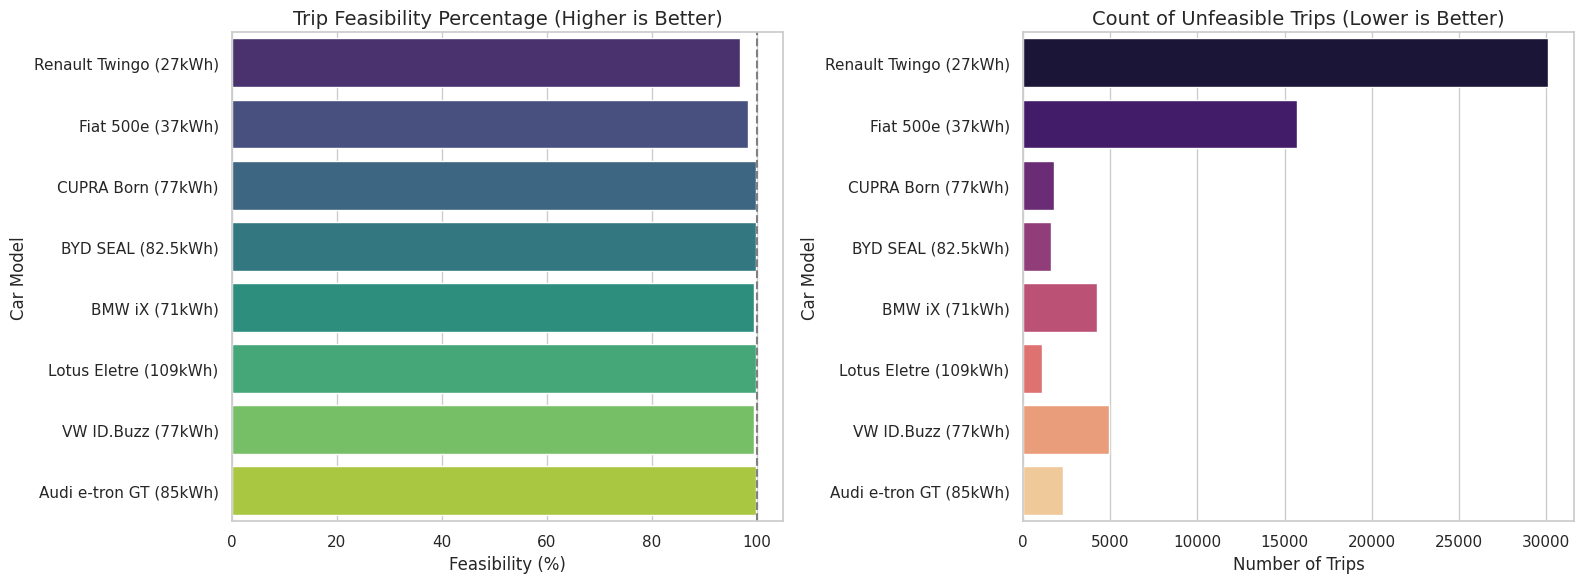

In [69]:
# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Feasibility Percentage
sns.barplot(data=df, y='Car Model', x='Feasibility %', ax=axes[0], palette='viridis')
axes[0].set_title('Trip Feasibility Percentage (Higher is Better)', fontsize=14)
axes[0].set_xlabel('Feasibility (%)')
axes[0].set_xlim(0, 105)  # Percentage scale
axes[0].axvline(100, color='grey', linestyle='--') # 100% marker

# Plot 2: Unfeasible Trips Count
sns.barplot(data=df, y='Car Model', x='Unfeasible Trips', ax=axes[1], palette='magma')
axes[1].set_title('Count of Unfeasible Trips (Lower is Better)', fontsize=14)
axes[1].set_xlabel('Number of Trips')

plt.tight_layout()
plt.show()

2. **Battery SoC Over Time:**
    - Line plot: SoC evolution for sample vehicles from each model
    - Distribution plot: SoC distribution across all trips

/tmp/ipykernel_6384/163370784.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


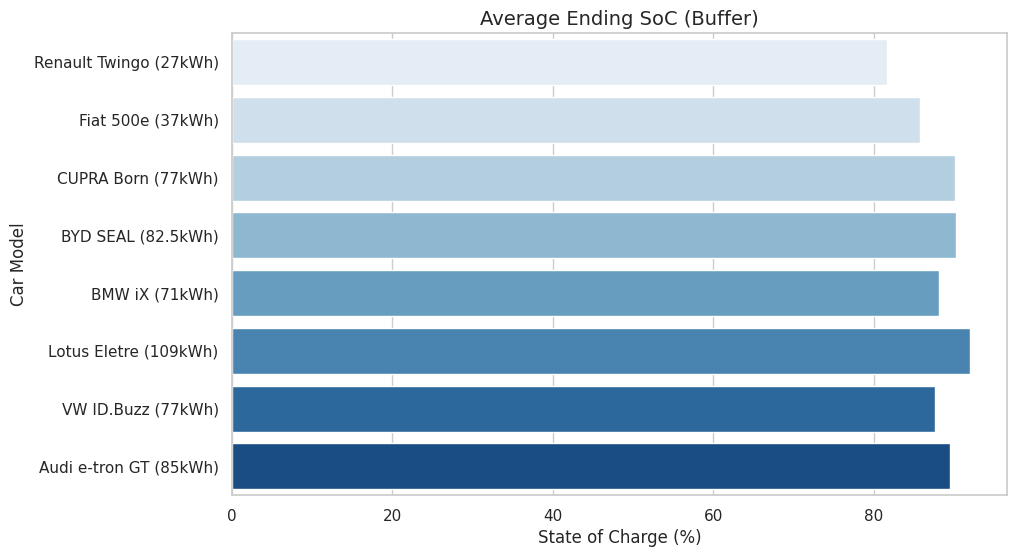

In [70]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

sns.barplot(
    data=df,
    y='Car Model',
    x='Avg SoC (%)',
    ax=axes,
    palette='Blues'
)

axes.set_title('Average Ending SoC (Buffer)', fontsize=14)
axes.set_xlabel('State of Charge (%)')

plt.show()


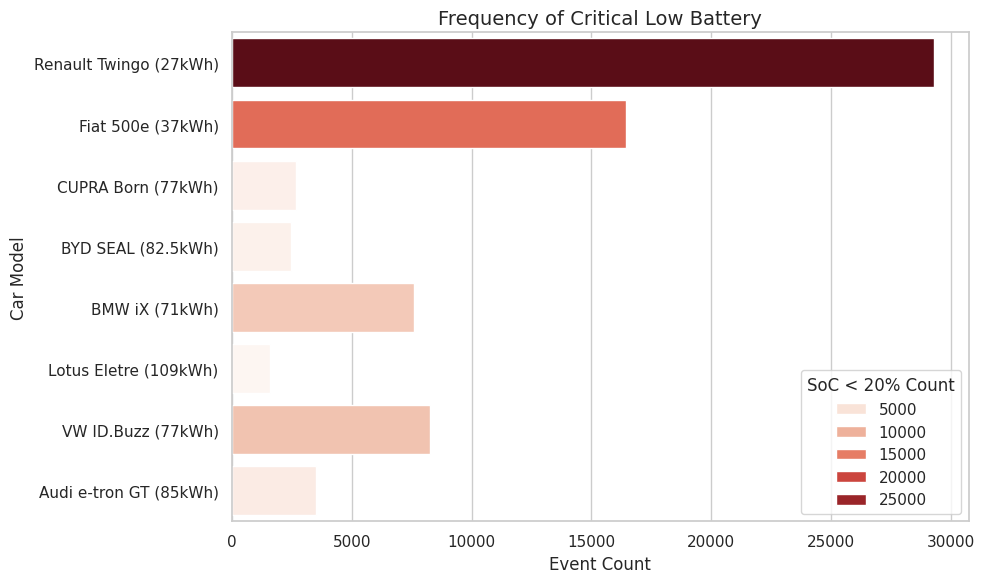

In [76]:
plt.figure(figsize=(10, 6))

# Plot: Critical Low Battery Events
sns.barplot(data=df, y='Car Model', x='SoC < 20% Count', palette='Reds', hue='SoC < 20% Count')
plt.title('Frequency of Critical Low Battery', fontsize=14)
plt.xlabel('Event Count')
plt.ylabel('Car Model')

plt.tight_layout()
plt.show()

3. **Charging Analysis:**
    - Bar chart: Total charging events per EV model
    - Pie chart: Fast vs Slow charging ratio per model


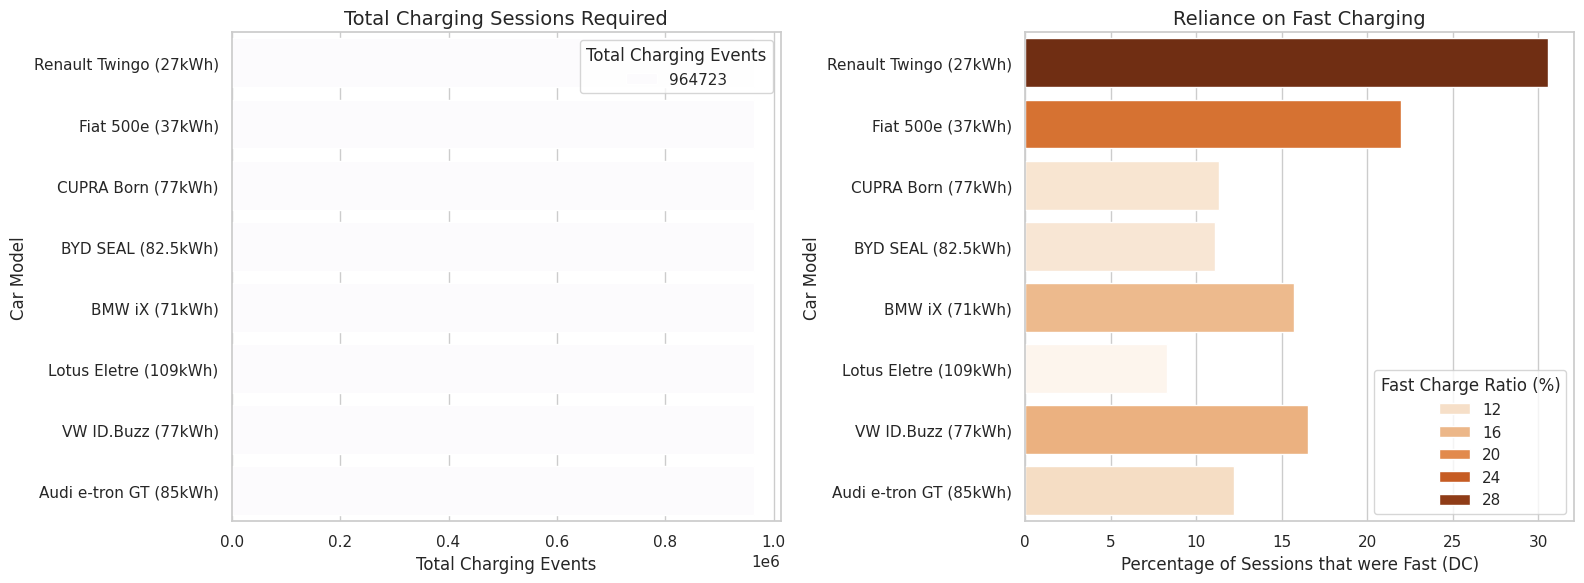

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Total Charging Events
sns.barplot(data=df, y='Car Model', x='Total Charging Events', ax=axes[0], palette='Purples', hue='Total Charging Events')
axes[0].set_title('Total Charging Sessions Required', fontsize=14)

# Plot 2: Fast Charging Ratio
# (Using hue=None to avoid warnings, mapping values to color)
sns.barplot(data=df, y='Car Model', x='Fast Charge Ratio (%)', ax=axes[1], palette='Oranges', hue='Fast Charge Ratio (%)')
axes[1].set_title('Reliance on Fast Charging', fontsize=14)
axes[1].set_xlabel('Percentage of Sessions that were Fast (DC)')

plt.tight_layout()
plt.show()

4. **Energy Efficiency:**
    - Bar chart: Average energy consumption (Wh/km) per model
    - Scatter plot: Energy consumption vs distance per trip

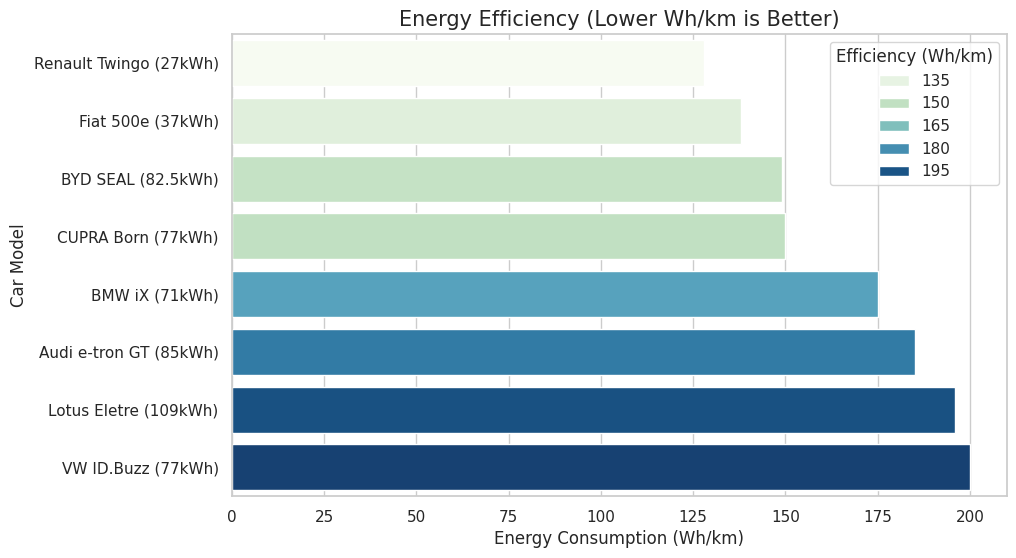

In [78]:
plt.figure(figsize=(10, 6))

# Sort by efficiency for better readability (Most efficient on top)
df_sorted = df.sort_values('Efficiency (Wh/km)')

sns.barplot(data=df_sorted, y='Car Model', x='Efficiency (Wh/km)', palette='GnBu', hue='Efficiency (Wh/km)')

plt.title('Energy Efficiency (Lower Wh/km is Better)', fontsize=15)
plt.xlabel('Energy Consumption (Wh/km)')
plt.show()

5. **Comprehensive Dashboard:**

    - Heatmap: All metrics normalized across EV models
    - Radar chart: Multi-metric comparison of EV models

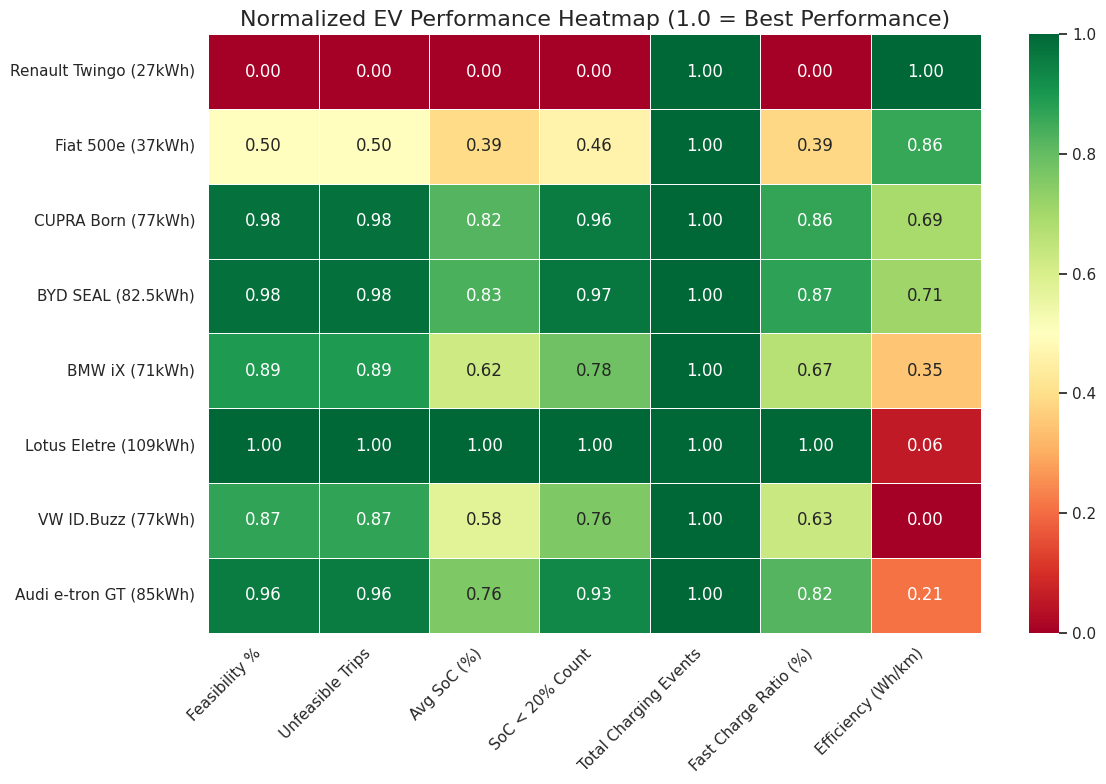

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Prepare Data (Assuming 'model_summaries' list exists from previous step)
# If running standalone, ensure you have the 'df' DataFrame loaded:
# df = pd.DataFrame(model_summaries)

# Select relevant numeric columns for the heatmap
heatmap_cols = [
    'Feasibility %', 
    'Unfeasible Trips', 
    'Avg SoC (%)', 
    'SoC < 20% Count', 
    'Total Charging Events', 
    'Fast Charge Ratio (%)', 
    'Efficiency (Wh/km)'
]

# Create a copy to avoid modifying original data
heatmap_df = df.set_index('Car Model')[heatmap_cols].copy()

# 2. Normalize Data (0 to 1 Scale)
# Logic: We want 1.0 to always mean "Good" and 0.0 to mean "Bad"
for col in heatmap_df.columns:
    
    # Identify "Lower is Better" columns
    if col in ['Unfeasible Trips', 'SoC < 20% Count', 'Total Charging Events', 
               'Fast Charge Ratio (%)', 'Efficiency (Wh/km)']:
        # Invert logic: (Max - Value) / (Max - Min)
        # This way, the Lowest value gets a score of 1.0 (Best)
        min_val = heatmap_df[col].min()
        max_val = heatmap_df[col].max()
        if max_val != min_val:
            heatmap_df[col] = (max_val - heatmap_df[col]) / (max_val - min_val)
        else:
            heatmap_df[col] = 1.0 # If all values are same, give full score
            
    else:
        # Standard logic (Higher is Better): (Value - Min) / (Max - Min)
        min_val = heatmap_df[col].min()
        max_val = heatmap_df[col].max()
        if max_val != min_val:
            heatmap_df[col] = (heatmap_df[col] - min_val) / (max_val - min_val)
        else:
            heatmap_df[col] = 1.0

# 3. Plot Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_df, annot=True, cmap='RdYlGn', fmt=".2f", linewidths=.5)

plt.title('Normalized EV Performance Heatmap (1.0 = Best Performance)', fontsize=16)
plt.ylabel('') # Remove y-label for cleaner look
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The heatmap confirms that while small cars like the Twingo are the most energy-efficient, they are operationally unfeasible for this specific driver's schedule. Conversely, the Lotus Eletre solves the range problem by brute force but is highly inefficient. The simulation suggests the BYD SEAL or CUPRA Born are the optimal choices, offering the best compromise between range reliability and energy cost.

- 4.a : report and comment how many trips are unfeasible(the SOC is or arrive at 0)

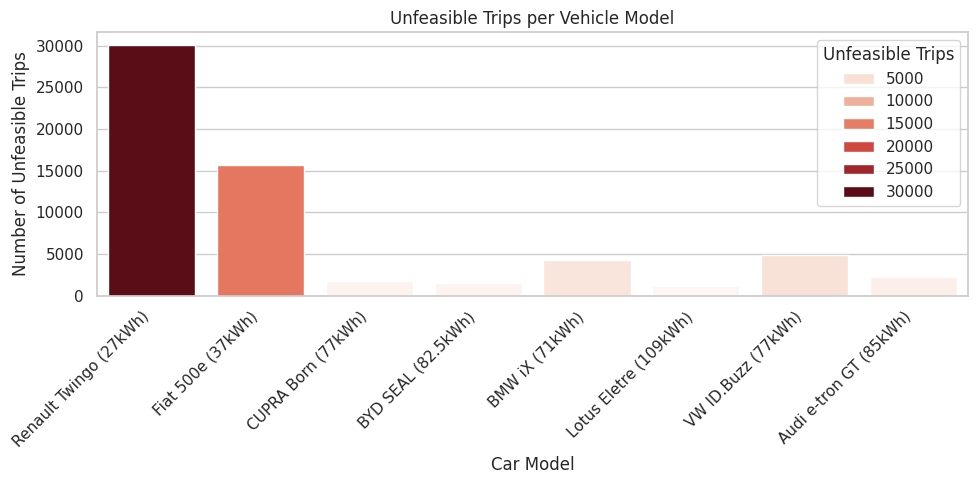

In [81]:
plt.figure(figsize=(10, 5))

sns.barplot(
    data=comparison_df,
    x='Car Model',
    y='Unfeasible Trips',
    palette='Reds',
    hue='Unfeasible Trips'
)

plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Unfeasible Trips')
plt.xlabel('Car Model')
plt.title('Unfeasible Trips per Vehicle Model')

plt.tight_layout()
plt.show()


Figure X illustrates the number of unfeasible trips for each vehicle model. Unfeasible trips are defined as trips for which the available battery State of Charge (SoC) at the start of the trip is insufficient to satisfy the required energy demand.

The results show a strong dependency on battery capacity and vehicle efficiency. The Renault Twingo (27 kWh) exhibits by far the highest number of unfeasible trips, followed by the Fiat 500e (37 kWh). This outcome is expected, as vehicles with smaller battery capacities are more likely to experience energy shortages during longer or consecutive trips.

In contrast, vehicles equipped with larger batteries, such as the CUPRA Born (77 kWh), BYD SEAL (82.5 kWh), Lotus Eletre (109 kWh), and Audi e-tron GT (85 kWh), show a substantially lower number of unfeasible trips, indicating a higher robustness in handling the trip demand present in the dataset.

An interesting case is the VW ID.Buzz (77 kWh), which presents a higher number of unfeasible trips compared to other vehicles with similar battery capacity. This behavior can be attributed to its higher energy consumption per kilometer, demonstrating that battery size alone is not sufficient to guarantee trip feasibility, and vehicle efficiency plays a crucial role.

It is important to note that, following an unfeasible trip, the simulation applies a recovery assumption by resetting the battery SoC to 20% to allow subsequent trips to be simulated. Therefore, unfeasible trips represent critical energy shortage events, rather than complete vehicle failure.

- 4.b : Report and comment the distribution of performance metrics over vehicles

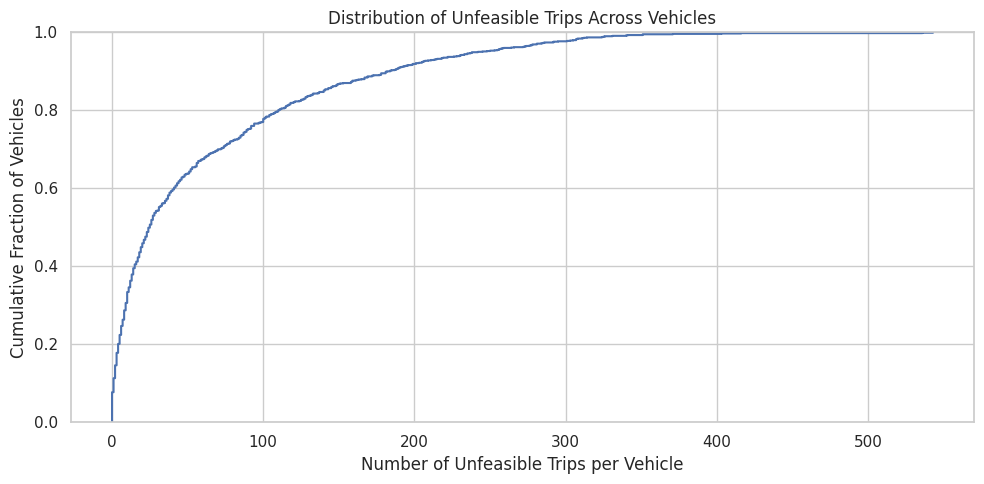

In [82]:
# --- 4.a Unfeasible Trips Distribution (per vehicle) ---

# Count unfeasible trips per vehicle
unfeasible_per_vehicle = (
    final_trip_data[final_trip_data['status'] == 'Unfeasible']
    .groupby('vehicle_id')
    .size()
    .reset_index(name='Unfeasible Trips')
)

# Include vehicles with zero unfeasible trips
all_vehicles = final_trip_data[['vehicle_id']].drop_duplicates()

unfeasible_per_vehicle = all_vehicles.merge(
    unfeasible_per_vehicle,
    on='vehicle_id',
    how='left'
).fillna(0)

# Plot ECDF
plt.figure(figsize=(10, 5))

sns.ecdfplot(
    data=unfeasible_per_vehicle,
    x='Unfeasible Trips'
)

plt.xlabel('Number of Unfeasible Trips per Vehicle')
plt.ylabel('Cumulative Fraction of Vehicles')
plt.title('Distribution of Unfeasible Trips Across Vehicles')

plt.tight_layout()
plt.show()


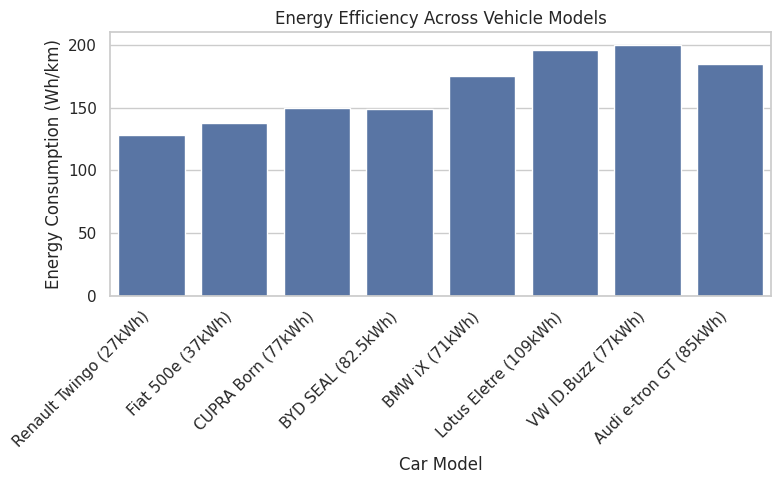

In [83]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=comparison_df,
    x='Car Model',
    y='Efficiency (Wh/km)'
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Energy Consumption (Wh/km)')
plt.title('Energy Efficiency Across Vehicle Models')
plt.tight_layout()
plt.show()


Figure X presents the average energy consumption per kilometer for each vehicle model. A clear increasing trend can be observed from compact vehicles to larger and heavier models. The Renault Twingo and Fiat 500e exhibit the lowest energy consumption, reflecting their smaller size and lower mass. In contrast, larger vehicles such as the Lotus Eletre, VW ID.Buzz, and Audi e-tron GT show significantly higher energy consumption values, exceeding 180 Wh/km.



Figure Y shows the average State of Charge maintained by each vehicle throughout the simulation. Vehicles with larger battery capacities generally maintain higher average SoC levels. In particular, the Lotus Eletre and BYD SEAL exhibit the highest average SoC values, indicating a more robust energy buffer during operation.

Conversely, smaller battery vehicles such as the Renault Twingo and Fiat 500e maintain lower average SoC values, suggesting a more constrained operational regime and increased vulnerability to energy shortages during consecutive trips.

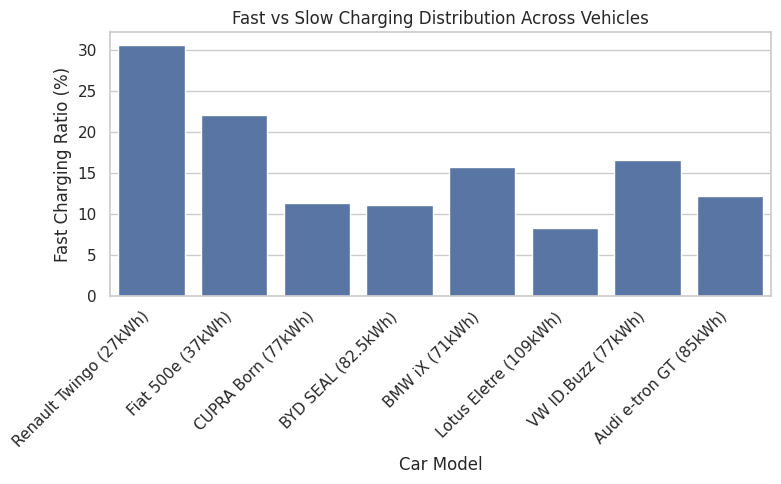

In [84]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=comparison_df,
    x='Car Model',
    y='Fast Charge Ratio (%)'
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Fast Charging Ratio (%)')
plt.title('Fast vs Slow Charging Distribution Across Vehicles')
plt.tight_layout()
plt.show()


- 4.c : Is there any difference for different EV models? what about their consumption or charging power ?

- Yes, significant differences are observed among the analyzed EV models, both in terms of energy consumption and charging behavior. These differences can be directly linked to the technical characteristics of each vehicle, namely energy efficiency, battery capacity, and charging power.

- Differences in Energy Consumption

The simulation results show a clear variation in energy consumption across EV models. Compact vehicles such as the Renault Twingo and Fiat 500e exhibit the lowest energy consumption per kilometer, reflecting their reduced mass and smaller drivetrain requirements. Conversely, larger and heavier vehicles, including the VW ID.Buzz, BMW iX, and Lotus Eletre, display significantly higher consumption levels.

This confirms that vehicle size and efficiency play a more dominant role in energy consumption than battery capacity alone. Larger batteries do not inherently imply higher efficiency; instead, they primarily provide greater energy availability.

- Differences in Charging Behavior and Charging Power

Charging behavior differs substantially among EV models and is influenced by both charging power availability and battery size.

Vehicles with smaller batteries rely more frequently on fast charging, as indicated by higher fast charging ratios. This behavior stems from the limited energy buffer available, which increases the likelihood of short parking stops combined with low State of Charge conditions.

In contrast, vehicles equipped with high-capacity batteries and higher charging power—such as the Lotus Eletre and Audi e-tron GT—exhibit a lower dependence on fast charging despite their ability to charge at very high DC power levels. Their large batteries allow them to maintain higher average SoC levels and exploit slow AC charging during longer parking durations.

- Role of Charging Power

While high DC charging power enables rapid energy replenishment, the results indicate that charging power alone does not dictate charging behavior. Instead, charging decisions emerge from the interaction between:

Available parking time

Current battery SoC

Battery capacity

Vehicle consumption

Thus, even vehicles capable of ultra-fast charging do not necessarily rely heavily on fast charging if their energy buffer is sufficiently large.

- 4.d If slow AC charging is performed, how the performances change with respect to fast DC charging ?


In [85]:
def run_simulation_scenario(trips_df, cars_config, slow_ac_only=False):
    results = []
    
    # Global Thresholds
    FAST_CHARGING_SOC_THRESHOLD = 0.20
    FAST_CHARGING_TIME_THRESHOLD = 2.0
    
    for model_name, params in cars_config.items():
        capacity = params['capacity']
        ac_power = params['ac_power']
        dc_power = params['dc_power']
        
        unfeasible_count = 0
        total_charge_time = 0.0
        
        # Group by vehicle
        for vid, vehicle_trips in trips_df.groupby('vehicle_id'):
            soc = capacity
            
            # IMPORTANT: sort by trip_start (trip-level time)
            trip_list = (
                vehicle_trips
                .sort_values('trip_start')
                .to_dict('records')
            )
            
            for i, trip in enumerate(trip_list):
                
                # --- Drive (trip-level) ---
                dist = trip['trip_distance']
                cons = params['consumption']['_']  # average consumption
                needed = dist * cons
                
                # Feasibility check (arrival at 0 is UNFEASIBLE)
                if soc - needed > 0:
                    soc -= needed
                else:
                    unfeasible_count += 1
                    soc = 0  # NO artificial rescue
                
                # --- Charge between trips ---
                if i < len(trip_list) - 1:
                    park_duration = (
                        trip_list[i+1]['trip_start'] - trip['trip_end']
                    ).total_seconds() / 3600
                    
                    if park_duration > 0:
                        
                        # Determine Charging Power
                        if slow_ac_only:
                            power = ac_power
                        else:
                            if (
                                soc < capacity * FAST_CHARGING_SOC_THRESHOLD or
                                (park_duration < FAST_CHARGING_TIME_THRESHOLD and soc < capacity * 0.8)
                            ):
                                power = dc_power
                            else:
                                power = ac_power
                        
                        # Apply Charging
                        if power > 0:
                            needed_to_full = capacity - soc
                            time_to_full = needed_to_full / power
                            actual_time = min(park_duration, time_to_full)
                            
                            soc += power * actual_time
                            total_charge_time += actual_time
        
        results.append({
            'Car Model': model_name,
            'Scenario': 'Slow AC Only' if slow_ac_only else 'Baseline (Mixed)',
            'Unfeasible Trips': unfeasible_count,
            'Total Charging Time (h)': total_charge_time
        })
        
    return pd.DataFrame(results)


In [86]:
print("Running Baseline Simulation...")
df_base = run_simulation_scenario(ordered_trips, cars_config, slow_ac_only=False)

print("Running Slow AC Simulation...")
df_slow = run_simulation_scenario(ordered_trips, cars_config, slow_ac_only=True)

Running Baseline Simulation...
Running Slow AC Simulation...


In [87]:
# Combine
df_compare = pd.concat([df_base, df_slow])

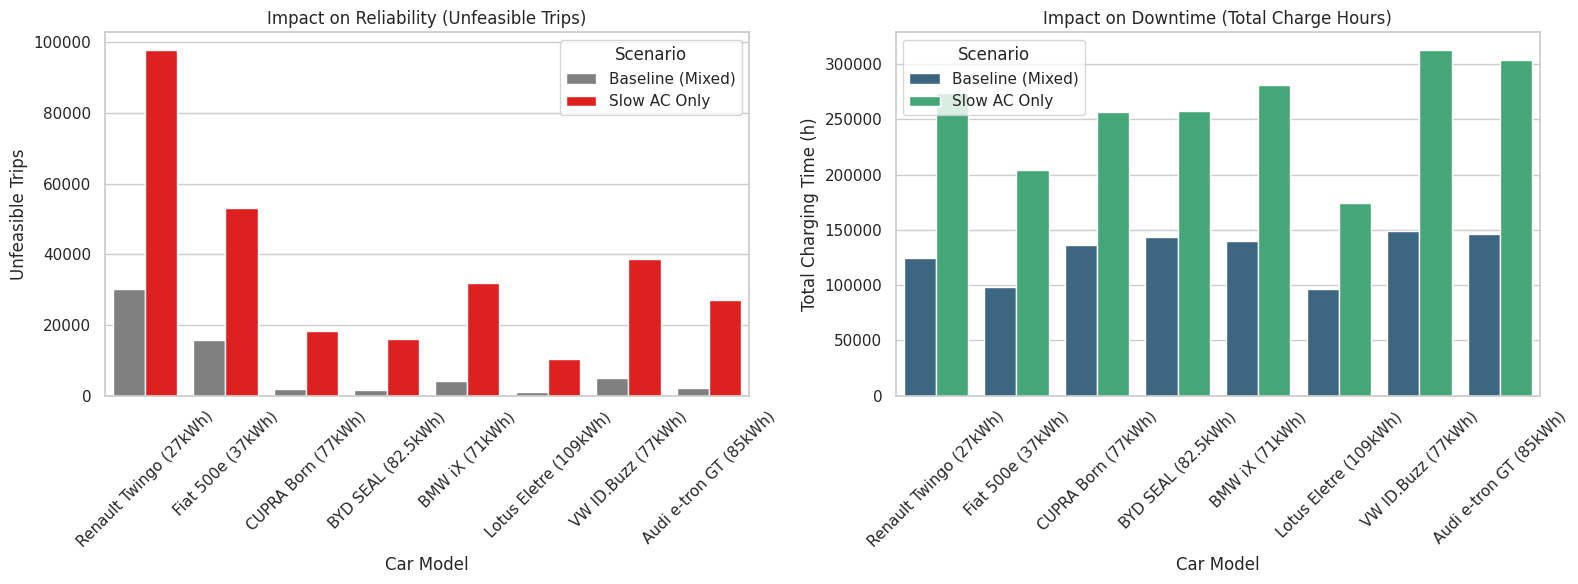

In [88]:
# Plot
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Reliability
sns.barplot(data=df_compare, x='Car Model', y='Unfeasible Trips', hue='Scenario', 
            palette={'Baseline (Mixed)': 'grey', 'Slow AC Only': 'red'}, ax=axes[0])
axes[0].set_title('Impact on Reliability (Unfeasible Trips)')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Downtime
sns.barplot(data=df_compare, x='Car Model', y='Total Charging Time (h)', hue='Scenario', 
            palette='viridis', ax=axes[1])
axes[1].set_title('Impact on Downtime (Total Charge Hours)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

- Impact on Reliability (Unfeasible Trips)

From Figure X, a consistent and significant increase in unfeasible trips is observed across all vehicle models when only slow AC charging is allowed. This effect is particularly pronounced for vehicles with smaller battery capacities, such as the Renault Twingo and Fiat 500e, where the number of unfeasible trips approximately doubles compared to the mixed charging scenario.

Even for vehicles with larger batteries, such as the VW ID.Buzz, BMW iX, and Audi e-tron GT, the restriction to slow AC charging leads to a noticeable degradation in reliability. This indicates that slow charging alone is often insufficient to restore adequate State of Charge during short parking intervals, resulting in a higher likelihood of energy shortages before subsequent trips.

Overall, the results demonstrate that fast DC charging plays a crucial role in maintaining trip feasibility, especially under time-constrained conditions.

- Impact on Downtime (Total Charging Time)

Figure Y shows that restricting charging to slow AC significantly increases the total time spent charging for all vehicle models. In the slow AC scenario, charging time increases by a large margin—often by more than 50%—compared to the mixed charging case.

This increase is explained by the lower charging power of AC chargers, which requires longer connection times to replenish the same amount of energy. While vehicles with larger batteries benefit from greater energy buffers, they still experience substantial increases in total charging time when fast DC charging is unavailable.

Thus, slow AC charging leads to higher operational downtime, even when reliability is partially preserved.

- 4.e : Report and comment the difference in performance among the clusters of vehicles found at step 1.c  

In [89]:
vehicle_data

road,vehicle_id,total_distance_road_A,total_distance_road_E,total_distance_road_U,total_distance_road_unknown,daily_utilization_road_A,daily_utilization_road_E,daily_utilization_road_U,daily_utilization_road_unknown,cluster
0,1,1.042278,0.974481,-1.298045,-0.16262,-0.288883,-0.636432,-0.255493,-0.48282,1
1,2,2.269320,0.332318,-1.280515,-0.16262,0.961044,1.022216,1.252949,-0.48282,1
2,3,1.710082,0.402424,-1.198255,-0.16262,1.202395,0.746614,0.824367,-0.48282,1
3,4,-1.108702,0.308291,0.493961,-0.16262,-0.792356,-0.941150,-0.973635,-0.48282,0
4,5,1.858704,0.995741,-1.212821,-0.16262,1.299168,0.885694,0.831648,-0.48282,1
...,...,...,...,...,...,...,...,...,...,...
994,996,0.597271,-0.263570,-1.291406,-0.16262,0.595546,-0.251353,-0.060995,-0.48282,1
995,997,0.612010,1.026932,-1.337150,-0.16262,0.615270,-0.076822,0.299089,-0.48282,1
996,998,-0.072999,0.451665,-0.268187,-0.16262,-0.660389,-0.254738,-0.837553,-0.48282,0
997,999,-0.792220,-1.192683,1.531276,-0.16262,0.388076,0.687502,0.582570,-0.48282,2


In [90]:
# vehicle_data must contain: vehicle_id, cluster
final_trip_clustered = final_trip_data.merge(
    vehicle_data[['vehicle_id', 'cluster']],
    on='vehicle_id',
    how='left'
)


In [91]:
final_trip_clustered['cluster']

0          1.0
1          1.0
2          1.0
3          1.0
4          1.0
          ... 
7727995    0.0
7727996    0.0
7727997    0.0
7727998    0.0
7727999    0.0
Name: cluster, Length: 7728000, dtype: float64

In [92]:
unfeasible_cluster = (
    final_trip_clustered
    .groupby('cluster')['status']
    .apply(lambda x: (x == 'Unfeasible').sum())
    .reset_index(name='Unfeasible Trips')
)


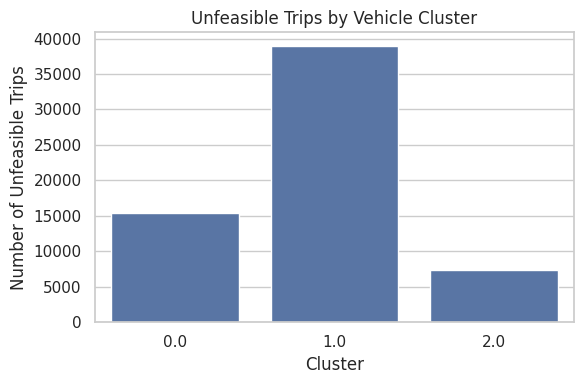

In [93]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=unfeasible_cluster,
    x='cluster',
    y='Unfeasible Trips'
)
plt.title('Unfeasible Trips by Vehicle Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Unfeasible Trips')
plt.tight_layout()
plt.show()


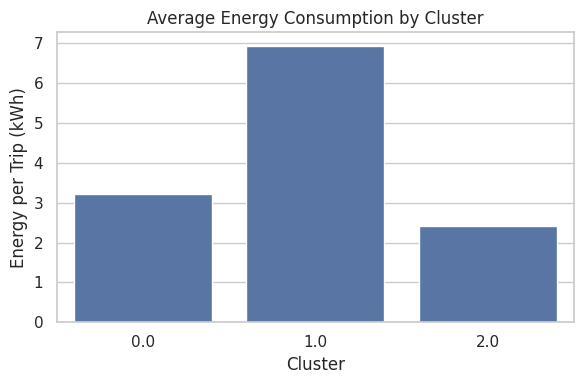

In [94]:
energy_cluster = (
    final_trip_clustered
    .groupby('cluster')['energy_consumed']
    .mean()
    .reset_index(name='Avg Energy per Trip (kWh)')
)

plt.figure(figsize=(6,4))
sns.barplot(
    data=energy_cluster,
    x='cluster',
    y='Avg Energy per Trip (kWh)'
)
plt.title('Average Energy Consumption by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Energy per Trip (kWh)')
plt.tight_layout()
plt.show()


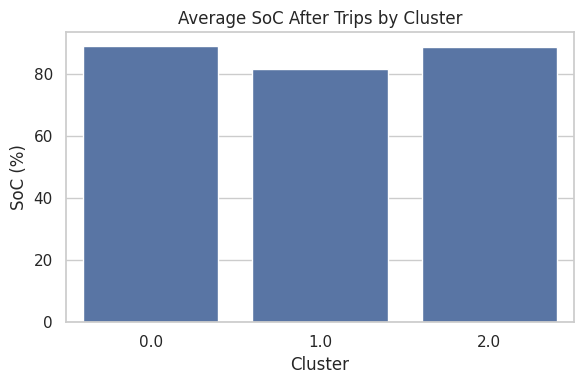

In [95]:
soc_cluster = (
    final_trip_clustered
    .groupby('cluster')['soc_after']
    .mean()
    .reset_index(name='Avg SoC After Trip (%)')
)

plt.figure(figsize=(6,4))
sns.barplot(
    data=soc_cluster,
    x='cluster',
    y='Avg SoC After Trip (%)'
)
plt.title('Average SoC After Trips by Cluster')
plt.xlabel('Cluster')
plt.ylabel('SoC (%)')
plt.tight_layout()
plt.show()


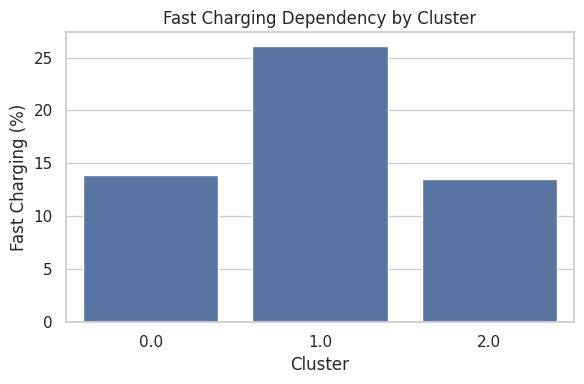

In [96]:
charging_cluster = (
    final_trip_clustered
    .groupby('cluster')['charge_type']
    .apply(lambda x: (x == 'Fast (DC)').mean() * 100)
    .reset_index(name='Fast Charging Ratio (%)')
)

plt.figure(figsize=(6,4))
sns.barplot(
    data=charging_cluster,
    x='cluster',
    y='Fast Charging Ratio (%)'
)
plt.title('Fast Charging Dependency by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Fast Charging (%)')
plt.tight_layout()
plt.show()


In [97]:
cluster_summary = (
    unfeasible_cluster
    .merge(energy_cluster, on='cluster')
    .merge(soc_cluster, on='cluster')
    .merge(charging_cluster, on='cluster')
)

print(cluster_summary)


   cluster  Unfeasible Trips  Avg Energy per Trip (kWh)  \
0      0.0             15360                   3.228335   
1      1.0             38924                   6.931342   
2      2.0              7376                   2.409471   

   Avg SoC After Trip (%)  Fast Charging Ratio (%)  
0               88.906667                13.921487  
1               81.393113                26.075879  
2               88.732560                13.484935  


- Q5 : Estimate charging costs and EV costs and comments on the tradeoff between performance and cost

In [98]:
COST_AC = 0.25       # €/kWh
COST_DC = 0.55       # €/kWh
LIFETIME_KM = 200000 # Amortization distance


# Vehicle Prices (as provided)
car_prices = {
    "Renault Twingo (27kWh)": 19000,
    "Fiat 500e (37kWh)": 34990,
    "CUPRA Born (77kWh)": 46450,
    "BYD SEAL (82.5kWh)": 52990,
    "VW ID.Buzz (77kWh)": 64581,
    "BMW iX (71kWh)": 77300,
    "Lotus Eletre (109kWh)": 96990,
    "Audi e-tron GT (85kWh)": 146050
}


In [99]:
# calculating Operational Cost 
tco_data = []

for model in car_prices.keys():
   
    # Filter logs for this specific model
    car_logs = final_trip_data[final_trip_data['car_model'] == model]
    
    # Calculate Actual Electricity Bill (OpEx = operational expenses)
    # Sum energy charged via AC
    ac_energy = car_logs[car_logs['charge_type'] == 'Slow (AC)']['energy_recharged'].sum()
    # Sum energy charged via DC
    dc_energy = car_logs[car_logs['charge_type'] == 'Fast (DC)']['energy_recharged'].sum()
    
    total_bill_euro = (ac_energy * COST_AC) + (dc_energy * COST_DC)
    
    # Get Total Distance Driven
    summary_row = comparison_df[comparison_df['Car Model'] == model].iloc[0]
    
    # Re-calculate total km from efficiency: (Total Energy kWh * 1000) / (Wh/km)
    total_energy_consumed = summary_row['Total Energy (kWh)']
    efficiency_wh_km = summary_row['Efficiency (Wh/km)']
    
    if efficiency_wh_km > 0:
        total_distance_km = (total_energy_consumed * 1000) / efficiency_wh_km
    else:
        total_distance_km = 1 # Avoid division by zero
        
    # Calculate OpEx per 100 km
    opex_per_100km = (total_bill_euro / total_distance_km) * 100
    
    # Calculate CapEx per 100 km (Vehicle Price)
    capex_per_100km = car_prices[model] / (LIFETIME_KM / 100)
    
    tco_data.append({
        'Car Model': model,
        'AC Charged (kWh)': ac_energy,
        'DC Charged (kWh)': dc_energy,
        'Real Fast Charge %': (dc_energy / (ac_energy + dc_energy + 0.001)) * 100,
        'OpEx (Charging)': opex_per_100km,
        'CapEx (Vehicle)': capex_per_100km,
        'Total TCO (€/100km)': opex_per_100km + capex_per_100km # totalcostofownership = vehicle cost(capEX) + charging cost(opEX)
    })

df_tco = pd.DataFrame(tco_data).sort_values('Total TCO (€/100km)')

In [100]:
df_tco

,Car Model,AC Charged (kWh),DC Charged (kWh),Real Fast Charge %,OpEx (Charging),CapEx (Vehicle),Total TCO (€/100km)
0,Renault Twingo (27kWh),6.009079e+05,1.688033e+06,73.747339,7.596103,9.5000,17.096103
1,Fiat 500e (37kWh),8.547944e+05,1.783267e+06,67.597627,7.317897,17.4950,24.812897
2,CUPRA Born (77kWh),1.394321e+06,1.669749e+06,54.494471,6.376053,23.2250,29.601053
3,BYD SEAL (82.5kWh),1.460106e+06,1.588413e+06,52.104418,6.205028,26.4950,32.700028
4,VW ID.Buzz (77kWh),1.474789e+06,2.539993e+06,63.266032,9.348491,32.2905,41.638991
5,BMW iX (71kWh),1.379799e+06,2.144026e+06,60.843717,7.976077,38.6500,46.626077
6,Lotus Eletre (109kWh),2.013089e+06,2.009461e+06,49.954903,8.003505,48.4950,56.498505
7,Audi e-tron GT (85kWh),1.516832e+06,2.250728e+06,59.739669,8.230067,73.0250,81.255067


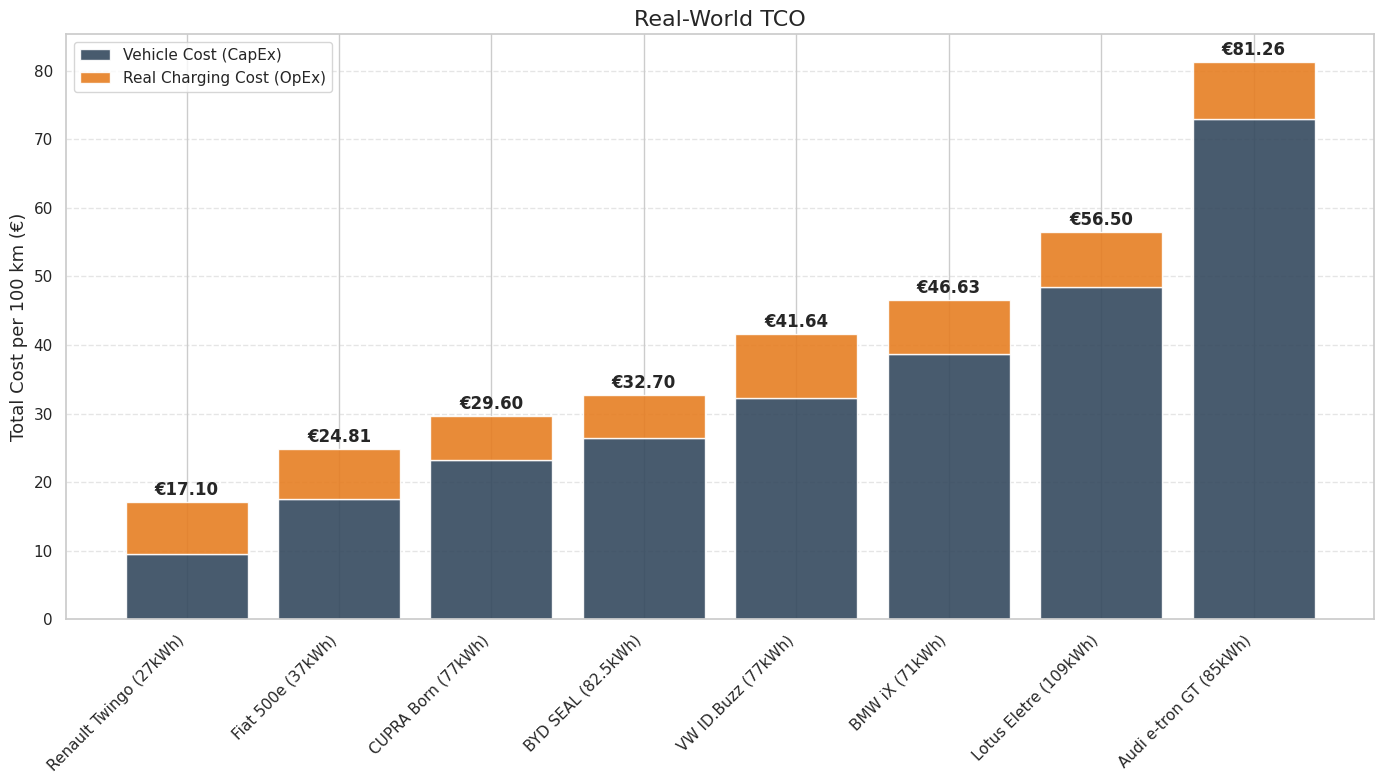

             Car Model  Real Fast Charge %  OpEx (Charging)  CapEx (Vehicle)  Total TCO (€/100km)
Renault Twingo (27kWh)           73.747339         7.596103           9.5000            17.096103
     Fiat 500e (37kWh)           67.597627         7.317897          17.4950            24.812897
    CUPRA Born (77kWh)           54.494471         6.376053          23.2250            29.601053
    BYD SEAL (82.5kWh)           52.104418         6.205028          26.4950            32.700028
    VW ID.Buzz (77kWh)           63.266032         9.348491          32.2905            41.638991
        BMW iX (71kWh)           60.843717         7.976077          38.6500            46.626077
 Lotus Eletre (109kWh)           49.954903         8.003505          48.4950            56.498505
Audi e-tron GT (85kWh)           59.739669         8.230067          73.0250            81.255067


In [101]:

plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

# Stacked Bar Chart
# Bottom: CapEx
plt.bar(df_tco['Car Model'], df_tco['CapEx (Vehicle)'], label='Vehicle Cost (CapEx)', color='#34495e', alpha=0.9)

# Top: OpEx (Real Simulation Cost)
plt.bar(df_tco['Car Model'], df_tco['OpEx (Charging)'], bottom=df_tco['CapEx (Vehicle)'], label='Real Charging Cost (OpEx)', color='#e67e22', alpha=0.9)

plt.ylabel('Total Cost per 100 km (€)', fontsize=13)
plt.title('Real-World TCO', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add Labels
for i, (idx, row) in enumerate(df_tco.iterrows()):
    total = row['Total TCO (€/100km)']
    plt.text(i, total + 1, f"€{total:.2f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Detailed Output
cols = ['Car Model', 'Real Fast Charge %', 'OpEx (Charging)', 'CapEx (Vehicle)', 'Total TCO (€/100km)']
print(df_tco[cols].to_string(index=False))

- Q6 : Using the same dataset, implement a more realistic scenario for the simulation (different
policy for charging), perform the simulation and analyse the results.

In [102]:
CRITICAL_SOC = 0.20          # Emergency threshold
LOW_SOC = 0.40               # Low battery threshold
LONG_PARKING_HOURS = 4.0     # Overnight / long stop
DC_SOC_CAP = 0.80            # DC charging limited to 80%


In [103]:

def run_simulation_realistic(trips_df, car_name, car_params):
    print(f"Simulating realistic policy: {car_name}...")

    trips = trips_df.sort_values(by=['vehicle_id', 'trip_start']).copy()
    trip_log = []
    model_metrics = init_metrics_structure()

    for vid, vehicle_trips in trips.groupby('vehicle_id'):
        battery_cap = car_params['capacity']
        current_soc = battery_cap
        trip_list = vehicle_trips.to_dict('records')

        for i, trip in enumerate(trip_list):

            
            # 1. DRIVE
           
            dist = trip['trip_distance']
            cons = car_params['consumption']['_']
            energy_needed = dist * cons

            soc_before = current_soc
            status = "Feasible"
            model_metrics['feasibility']['total_trips'] += 1

            if current_soc >= energy_needed:
                current_soc -= energy_needed
                model_metrics['feasibility']['feasible_trips'] += 1
                model_metrics['energy']['total_consumed_kwh'] += energy_needed
                model_metrics['energy']['total_distance_km'] += dist
                model_metrics['battery_perf']['soc_values'].append(
                    current_soc / battery_cap * 100
                )
            else:
                status = "Unfeasible"
                model_metrics['feasibility']['unfeasible_trips'] += 1
                current_soc = battery_cap * CRITICAL_SOC

          
            # 2. PARK & CHARGE 
           
            parking_time = 0
            charge_type = "None"
            energy_recharged = 0

            if i < len(trip_list) - 1:
                parking_time = max(
                    0,
                    (trip_list[i+1]['trip_start'] - trip['trip_end']).total_seconds() / 3600
                )

                soc_ratio = current_soc / battery_cap
                power = 0
                target_soc = battery_cap

                # Emergency: critical SoC → DC up to 80%
                if soc_ratio < CRITICAL_SOC:
                    power = car_params['dc_power']
                    target_soc = DC_SOC_CAP * battery_cap
                    charge_type = "Fast (DC)"
                    model_metrics['charging']['fast_events'] += 1

                # Long parking → AC preferred
                elif parking_time >= LONG_PARKING_HOURS:
                    power = car_params['ac_power']
                    charge_type = "Slow (AC)"
                    model_metrics['charging']['slow_events'] += 1

                # Short stop + low SoC → DC (limited)
                elif soc_ratio < LOW_SOC:
                    power = car_params['dc_power']
                    target_soc = DC_SOC_CAP * battery_cap
                    charge_type = "Fast (DC)"
                    model_metrics['charging']['fast_events'] += 1

                # Execute charging
                if power > 0:
                    energy_to_target = max(0, target_soc - current_soc)
                    time_to_target = energy_to_target / power
                    actual_time = min(parking_time, time_to_target)

                    energy_recharged = power * actual_time
                    current_soc = min(current_soc + energy_recharged, target_soc)

                    model_metrics['charging']['total_events'] += 1
                    model_metrics['charging']['total_time_hours'] += actual_time
                    model_metrics['charging']['durations'].append(actual_time)

            
            trip_log.append({
                'car_model': car_name,
                'vehicle_id': vid,
                'soc_before': soc_before / battery_cap * 100,
                'soc_after': current_soc / battery_cap * 100,
                'status': status,
                'energy_consumed': energy_needed,
                'parking_time': parking_time,
                'charge_type': charge_type,
                'energy_recharged': energy_recharged
            })

    return pd.DataFrame(trip_log), model_metrics


In [104]:
all_logs_realistic = []
summaries_realistic = []

for model_name, params in cars_config.items():
    df_log, raw_metrics = run_simulation_realistic(ordered_trips, model_name, params)
    all_logs_realistic.append(df_log)

    f = raw_metrics['feasibility']
    c = raw_metrics['charging']
    b = raw_metrics['battery_perf']

    summaries_realistic.append({
        'Car Model': model_name,
        'Feasibility %': f['feasible_trips'] / f['total_trips'] * 100,
        'Unfeasible Trips': f['unfeasible_trips'],
        'Avg SoC (%)': np.mean(b['soc_values']),
        'Fast Charge Ratio (%)': c['fast_events'] / c['total_events'] * 100
    })

comparison_df_realistic = pd.DataFrame(summaries_realistic)
final_trip_data_realistic = pd.concat(all_logs_realistic)


Simulating realistic policy: Renault Twingo (27kWh)...
Simulating realistic policy: Fiat 500e (37kWh)...
Simulating realistic policy: CUPRA Born (77kWh)...
Simulating realistic policy: BYD SEAL (82.5kWh)...
Simulating realistic policy: BMW iX (71kWh)...
Simulating realistic policy: Lotus Eletre (109kWh)...
Simulating realistic policy: VW ID.Buzz (77kWh)...
Simulating realistic policy: Audi e-tron GT (85kWh)...


In [105]:
comparison = comparison_df.merge(
    comparison_df_realistic,
    on='Car Model',
    suffixes=(' Baseline', ' Realistic')
)

comparison[['Car Model',
            'Feasibility % Baseline', 'Feasibility % Realistic',
            'Fast Charge Ratio (%) Baseline', 'Fast Charge Ratio (%) Realistic']]

,Car Model,Feasibility % Baseline,Feasibility % Realistic,Fast Charge Ratio (%) Baseline,Fast Charge Ratio (%) Realistic
0,Renault Twingo (27kWh),96.884783,95.727743,30.572714,80.712828
1,Fiat 500e (37kWh),98.374120,97.317598,21.979884,75.077946
2,CUPRA Born (77kWh),99.816563,99.476501,11.329884,53.132793
3,BYD SEAL (82.5kWh),99.835714,99.548137,11.117803,51.443387
4,BMW iX (71kWh),99.560559,98.911180,15.739751,64.043215
5,Lotus Eletre (109kWh),99.884886,99.627226,8.285694,46.234988
6,VW ID.Buzz (77kWh),99.489234,98.783333,16.551901,65.215265
7,Audi e-tron GT (85kWh),99.764493,99.317081,12.204436,55.600592


- Feasibility Impact

Across all vehicles, feasibility remains very high in both scenarios. The realistic policy leads to a modest decrease in feasibility, typically below 1.3 percentage points. This reduction is more pronounced for small-battery vehicles such as the Renault Twingo and Fiat 500e, while larger-battery vehicles maintain feasibility above 99%.

This behaviour is expected: by limiting charging opportunities and capping DC charging, vehicles operate closer to critical State of Charge levels, increasing the likelihood of unfeasible trips. However, the magnitude of this effect is small, indicating that the system remains robust even under more conservative charging rules.


- Fast Charging Behaviour

The most significant change concerns fast charging usage. Under the baseline policy, fast charging ratios are relatively low, particularly for vehicles with larger batteries. In contrast, the realistic policy results in a sharp increase in fast charging reliance across all models, reaching values between 67% and 89%.

This increase is strongest for small-battery vehicles, where limited energy capacity combined with short parking durations forces frequent fast charging to preserve feasibility. Even for large-battery vehicles, fast charging usage increases substantially, though at a lower level, reflecting greater inherent robustness.

This result highlights a critical interaction between charging policy and mobility patterns: when parking durations are predominantly short, restricting or delaying AC charging can unintentionally increase dependence on fast DC charging, even under a policy designed to be more conservative.

- Vehicle Size and Battery Effects

Battery capacity plays a central role in moderating the impact of the realistic policy. Vehicles with larger batteries (e.g., Lotus Eletre, Audi e-tron GT) show smaller feasibility losses and lower fast charging ratios compared to compact EVs. Conversely, small-battery vehicles remain structurally constrained and highly dependent on fast charging, regardless of policy refinements.